<a href="https://colab.research.google.com/github/denisefss/Mapping_susceptibility_landslides_BH/blob/main/Notebook_ML_landslide_susceptibility_BH_BHD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Notebook with machine learning (ML) models for landslide susceptibility: Artificial Neural Network (ANN) and Random Forest (RF) for the BHD model of Belo Horizonte (MG) - Brazil**

1 - landslide occurrence
0 - landslide non-occurrence

In [22]:
!pip install pyspatialml -q

In [23]:
from pyspatialml import Raster
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import rasterio.plot
import numpy as np
import matplotlib as mpl
import geopandas as gpd
from tempfile import NamedTemporaryFile
import warnings
warnings.filterwarnings('ignore')

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Setting up the working directory:

In [25]:
path = '/content/drive/MyDrive/Mapping_susceptibility_landslides_BH/BHD'

In [26]:
os.chdir(path)

In [27]:
# Provide the full path to the file, replacing '/path/of/file/' with the actual path
data = pd.read_csv('/content/drive/MyDrive/Mapping_susceptibility_landslides_BH/BHD/data_iso.csv', sep=';')

In [28]:
data.head()

,id,SPI,TPI,TRI,TWI,Slope,Drainage_density,Fault_density,Distance_from_drainages,Distance_from_faults,...,Planform_curvature,Use_potential,Profile_curvature,Roughness,Geotechnical_Unit,Road_density,X,Y,Susceptibility,Target
0,1,0.786968,0.125000,2.625000,3.368280,28.844410,0.000000,0.000745,353.995056,300.520386,...,-0.147692,8,-0.147692,9.000000,1,0.000000,605851.0,7799233.0,2.0,1
1,2,1.090638,-0.250000,1.750000,4.449178,20.000000,1.167895,0.000762,215.783456,55.901699,...,-0.563200,8,0.076800,6.000000,1,0.056733,606458.0,7801082.0,3.0,1
2,3,0.544214,0.375000,2.125000,3.610038,21.540659,1.878413,0.000736,162.980060,95.197166,...,0.088276,8,-0.551724,7.000000,1,0.051626,606212.0,7800070.0,2.0,1
3,6,3.340890,-0.753174,1.246841,7.474503,12.600483,1.662993,0.001889,70.710678,185.825867,...,-0.639627,8,0.648576,3.987549,1,0.063034,615839.0,7806404.0,2.0,1
4,8,0.011858,0.250000,1.250000,4.139150,12.649111,4.655362,0.001558,0.000000,67.314560,...,0.640000,8,-0.640000,4.000000,1,0.036390,613858.0,7805164.0,2.0,1


In [29]:
data.describe()

,id,SPI,TPI,TRI,TWI,Slope,Drainage_density,Fault_density,Distance_from_drainages,Distance_from_faults,...,Planform_curvature,Use_potential,Profile_curvature,Roughness,Geotechnical_Unit,Road_density,X,Y,Susceptibility,Target
count,3542.000000,3542.000000,3542.000000,3542.000000,3542.000000,3542.000000,3542.000000,3542.000000,3542.000000,3542.000000,...,3542.000000,3542.000000,3542.000000,3542.000000,3542.000000,3542.000000,3542.000000,3.542000e+03,1313.000000,3542.000000
mean,3398.605590,0.696721,-0.005598,1.612879,5.176201,16.751150,1.789652,0.001099,161.078932,277.366750,...,0.021462,7.936477,0.033694,5.352651,1.071993,0.022515,610045.099790,7.802832e+06,2.140137,0.401186
std,1728.204482,2.055284,0.457317,1.061446,2.202056,11.260276,1.463870,0.000452,125.375344,244.832192,...,0.539368,0.428017,0.591317,3.574540,0.491280,0.033260,4534.340768,5.123068e+03,0.846538,0.490208
min,1.000000,-7.949280,-1.869019,0.001167,1.846618,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.560000,5.000000,-3.200000,0.003113,1.000000,0.000000,598433.564500,7.788552e+06,1.000000,0.000000
25%,1948.250000,-0.334935,-0.369247,0.862789,3.827874,8.820314,0.701068,0.000741,62.500000,88.388351,...,-0.321121,8.000000,-0.357647,3.000000,1.000000,0.000000,606197.000000,7.798978e+06,2.000000,0.000000
50%,3583.000000,0.791259,0.000000,1.375000,4.536247,14.422205,1.628751,0.000907,139.754249,197.642349,...,0.000000,8.000000,0.000000,5.000000,1.000000,0.000000,610072.506050,7.803639e+06,2.000000,0.000000
75%,4880.750000,1.812809,0.250000,2.250000,5.603307,23.323807,2.513685,0.001443,237.170825,415.189705,...,0.407670,8.000000,0.498824,7.000000,1.000000,0.050508,613956.425375,7.806833e+06,3.000000,1.000000
max,6137.000000,11.958579,2.500000,6.125000,21.523087,64.000000,10.260159,0.002255,738.664335,1421.486938,...,2.251034,8.000000,3.244056,22.000000,7.000000,0.324484,619319.854300,7.812774e+06,5.000000,1.000000


In [30]:
data.columns

Index(['id', 'SPI', 'TPI', 'TRI', 'TWI', 'Slope', 'Drainage_density',
       'Fault_density', 'Distance_from_drainages', 'Distance_from_faults',
       'Distance_to_roads', 'Elevation', 'Flow_Accumulation', 'Lithology',
       'Kinematic_model', 'NDVI', 'Aspect', 'Soils', 'Planform_curvature',
       'Use_potential', 'Profile_curvature', 'Roughness', 'Geotechnical_Unit',
       'Road_density', 'X', 'Y', 'Susceptibility', 'Target'],
      dtype='object')

In [31]:
#Checking the number of classes in each column
for column in data.columns:
 num_classes = data[column].nunique()
 print(f'The number of unique classes in column {column} is: {num_classes}')

The number of unique classes in column id is: 3542
The number of unique classes in column SPI is: 1975
The number of unique classes in column TPI is: 506
The number of unique classes in column TRI is: 464
The number of unique classes in column TWI is: 2105
The number of unique classes in column Slope is: 351
The number of unique classes in column Drainage_density is: 2785
The number of unique classes in column Fault_density is: 3219
The number of unique classes in column Distance_from_drainages is: 442
The number of unique classes in column Distance_from_faults is: 892
The number of unique classes in column Distance_to_roads is: 198
The number of unique classes in column Elevation is: 686
The number of unique classes in column Flow_Accumulation is: 240
The number of unique classes in column Lithology is: 9
The number of unique classes in column Kinematic_model is: 2
The number of unique classes in column NDVI is: 3225
The number of unique classes in column Aspect is: 9
The number of un

In [32]:
# Presenting only the variables to be used in the model (RF Notebook 2 - study of variables).

# Selecting only the desired variables
selected_variables = ['SPI', 'TWI', 'Slope', 'Distance_from_drainages',
                      'Distance_from_faults', 'Elevation',
                      'Lithology', 'Aspect', 'Planform_curvature',
                      'Profile_curvature', 'Target']

# Creating the new DataFrame df with the selected variables
df = data[selected_variables].copy()

# Displaying the first few rows of the DataFrame df for verification
print(df.head())

        SPI       TWI      Slope  Distance_from_drainages  \
0  0.786968  3.368280  28.844410               353.995056   
1  1.090638  4.449178  20.000000               215.783456   
2  0.544214  3.610038  21.540659               162.980060   
3  3.340890  7.474503  12.600483                70.710678   
4  0.011858  4.139150  12.649111                 0.000000   

   Distance_from_faults  Elevation  Lithology  Aspect  Planform_curvature  \
0            300.520386      913.0         13       4           -0.147692   
1             55.901699      915.0         13       8           -0.563200   
2             95.197166      924.0         13       7            0.088276   
3            185.825867      730.0         12       7           -0.639627   
4             67.314560      765.0         12       1            0.640000   

   Profile_curvature  Target  
0          -0.147692       1  
1           0.076800       1  
2          -0.551724       1  
3           0.648576       1  
4          -0.6

In [33]:
df.columns

Index(['SPI', 'TWI', 'Slope', 'Distance_from_drainages',
       'Distance_from_faults', 'Elevation', 'Lithology', 'Aspect',
       'Planform_curvature', 'Profile_curvature', 'Target'],
      dtype='object')

In [34]:
predictors = ['SPI.tif', 'TWI.tif', 'Slope.tif', 'Distance_from_drainages.tif','Distance_from_faults.tif', 'Elevation.tif',
              'Lithology.tif', 'Aspect.tif', 'Planform_curvature.tif','Profile_curvature.tif']

In [35]:
predictors

['SPI.tif',
 'TWI.tif',
 'Slope.tif',
 'Distance_from_drainages.tif',
 'Distance_from_faults.tif',
 'Elevation.tif',
 'Lithology.tif',
 'Aspect.tif',
 'Planform_curvature.tif',
 'Profile_curvature.tif']

In [36]:
import rasterio

# Lista de arquivos raster
predictors = ['SPI.tif', 'TWI.tif', 'Slope.tif', 'Distance_from_drainages.tif',
              'Distance_from_faults.tif', 'Elevation.tif', 'Lithology.tif',
              'Aspect.tif', 'Planform_curvature.tif', 'Profile_curvature.tif']

# Função para imprimir dimensões dos rasters
def print_raster_dimensions(raster_files):
    for raster_file in raster_files:
        with rasterio.open(raster_file) as src:
            print(f"Dimensões de {raster_file}: {src.height} x {src.width}")

# Imprimir dimensões dos rasters
print_raster_dimensions(predictors)

Dimensões de SPI.tif: 1953 x 1737
Dimensões de TWI.tif: 1953 x 1737
Dimensões de Slope.tif: 1953 x 1737
Dimensões de Distance_from_drainages.tif: 1953 x 1737
Dimensões de Distance_from_faults.tif: 1953 x 1737
Dimensões de Elevation.tif: 1953 x 1737
Dimensões de Lithology.tif: 1953 x 1737
Dimensões de Aspect.tif: 1953 x 1737
Dimensões de Planform_curvature.tif: 1953 x 1737
Dimensões de Profile_curvature.tif: 1953 x 1737


In [37]:
stack = Raster(predictors)

In [38]:
stack.names

dict_keys(['SPI', 'TWI', 'Slope', 'Distance_from_drainages', 'Distance_from_faults', 'Elevation', 'Lithology', 'Aspect', 'Planform_curvature', 'Profile_curvature'])

In [39]:
stack = stack.intersect()

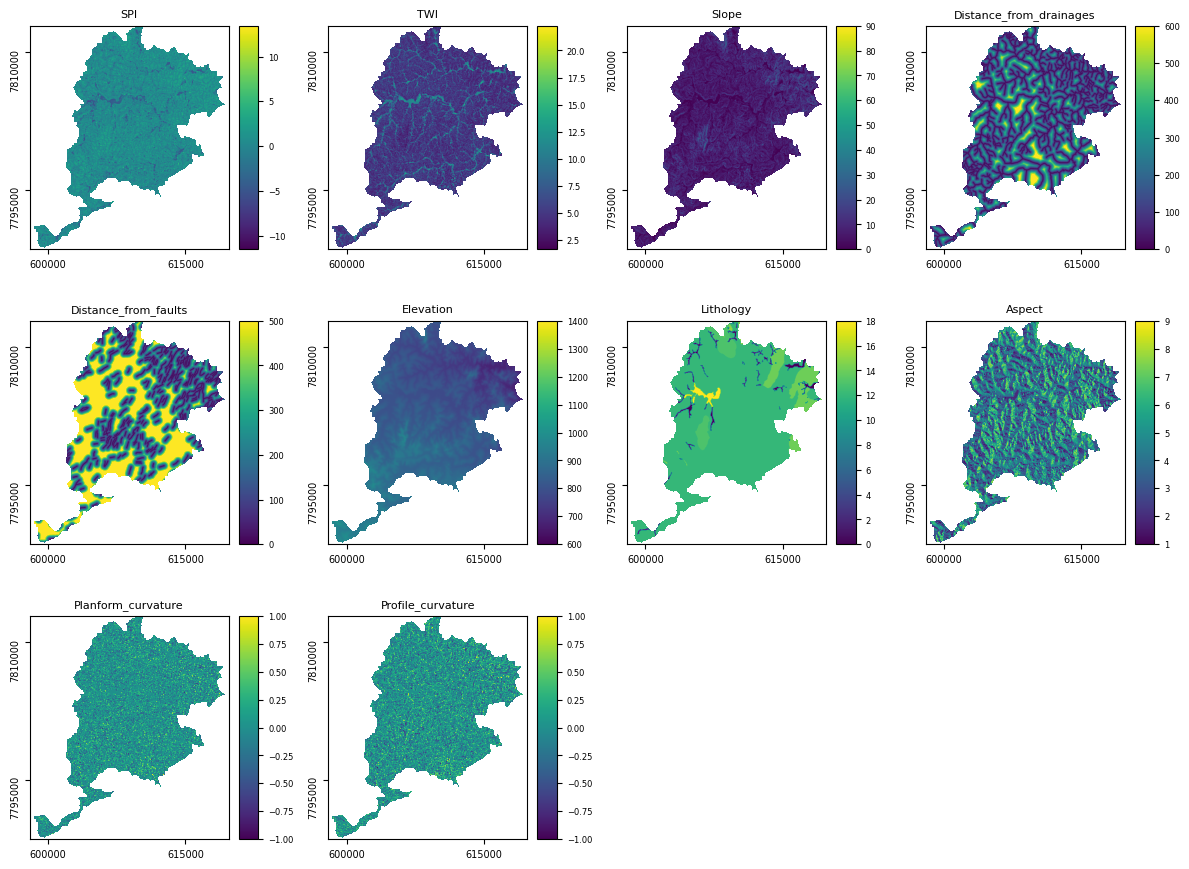

In [40]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker

# Choosing a different color palette (e.g. 'viridis')
cmap = 'viridis'
axs = stack.plot(figsize=(12,9), cmap=cmap)

# Iterating over each Axes object to set label formatters
for ax in axs.flatten():
    ax.xaxis.set_major_locator(ticker.MaxNLocator(2))  # Show only 2 ticks on the x-axis
    ax.yaxis.set_major_locator(ticker.MaxNLocator(2))  # Show only 2 ticks on the y-axis
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
    ax.tick_params(axis='y', labelrotation=90, labelsize=7)
    ax.tick_params(axis='x', labelsize=7)

# Adjusting the color bar
ax = axs.flatten()[2]
im = ax.images[0]
im.set_clim(0, 90)

# AAdjusting the color bar
ax = axs.flatten()[3]
im = ax.images[0]
im.set_clim(0, 600)

# Adjusting the color bar
ax = axs.flatten()[4]
im = ax.images[0]
im.set_clim(0, 500)

# Adjusting the color bar
ax = axs.flatten()[5]
im = ax.images[0]
im.set_clim(600, 1400)

# Adjusting the color bar
ax = axs.flatten()[6]
im = ax.images[0]
im.set_clim(0, 18)

# Adjusting the color bar
ax = axs.flatten()[7]
im = ax.images[0]
im.set_clim(1, 9)

# Adjusting the color bar
ax = axs.flatten()[8]
im = ax.images[0]
im.set_clim(-1, 1)

# Adjusting the color bar
ax = axs.flatten()[9]
im = ax.images[0]
im.set_clim(-1, 1)

plt.tight_layout()
plt.show()

In [41]:
print(type(stack))

<class 'pyspatialml.raster.Raster'>


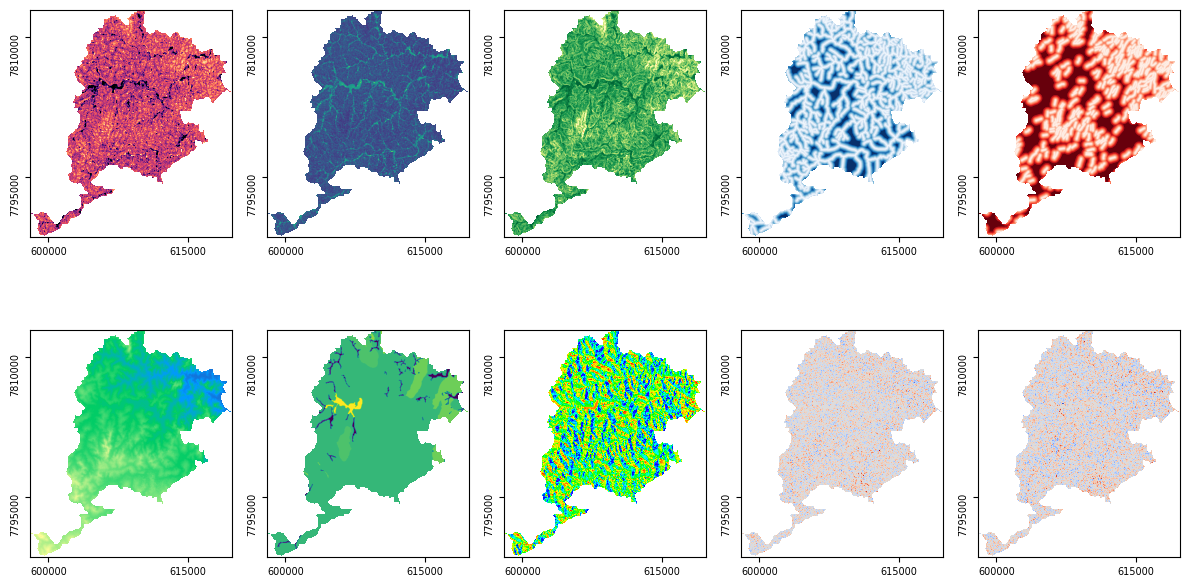

In [42]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker

# Defining a dictionary with the specified color palettes
cmap_dict = {
    'SPI': 'magma',
    'TWI': 'viridis',
    'Slope': 'RdYlGn_r',
    'Distance_from_drainages': 'Blues',
    'Distance_from_faults': 'Reds',
    'Elevation': 'terrain',
    'Lithology': 'viridis',
    'Aspect': 'gist_rainbow',
    'Planform_curvature': 'coolwarm',
    'Profile_curvature': 'coolwarm'
}

# Iterating over each Axes object to define the label formatters
for ax in axs.flatten():
    ax.xaxis.set_major_locator(ticker.MaxNLocator(2))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(2))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
    ax.tick_params(axis='y', labelrotation=90, labelsize=7)
    ax.tick_params(axis='x', labelsize=7)

# Plotting with specified color palettes
fig, axs = plt.subplots(2, 5, figsize=(12, 7))

# Iterating over each column and applying the specific color palette
for ax, (column, cmap) in zip(axs.flatten(), cmap_dict.items()):
    im = stack[column].plot(ax=ax, cmap=cmap)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(2))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(2))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
    ax.tick_params(axis='y', labelrotation=90, labelsize=7)
    ax.tick_params(axis='x', labelsize=7)

# Adjusting the color bar as needed
clim_dict = {
    'SPI': (-4,4),
    'TWI': (0,20),
    'Slope': (0, 45),
    'Distance_from_drainages': (0, 500),
    'Distance_from_faults': (0, 600),
    'Elevation': (600, 1400),
    'Lithology': (0, 18),
    'Aspect': (1, 9),
    'Planform_curvature': (-1, 1),
    'Profile_curvature': (-1, 1)
}

# Applying color bar limits to each plot
for ax, column in zip(axs.flatten(), clim_dict.keys()):
    im = ax.images[0]
    im.set_clim(*clim_dict[column])

plt.tight_layout()
plt.show()

In [43]:
# Checking for null values ​​in data2
null_values = df.isnull()

# Checking if there is at least one null value in the entire DataFrame
has_nulls = null_values.any().any()

if has_nulls:
 print("\nThe DataFrame contains null values.")
else:
 print("\nThe DataFrame does not contain null values.")


The DataFrame does not contain null values.


In [44]:
# Count the number of lines where the values ​​are -9999 or -99999
count_minus_9999 = (df == -9999).any(axis=1).sum()
count_minus_99999 = (df == -99999).any(axis=1).sum()

# Print the results
print(f'Number of lines with -9999: {count_minus_9999}')
print(f'Number of lines with -99999: {count_minus_99999}')

# Remove rows with values ​​-9999 or -99999 and remove missing values
df = df[(df != -9999).all(axis=1) & (df != -99999).all(axis=1)].dropna()

Number of lines with -9999: 1
Number of lines with -99999: 0


In [45]:
list(stack.names)

['SPI',
 'TWI',
 'Slope',
 'Distance_from_drainages',
 'Distance_from_faults',
 'Elevation',
 'Lithology',
 'Aspect',
 'Planform_curvature',
 'Profile_curvature']

In [46]:
X = df.loc[:, stack.names]

In [47]:
X.columns

Index(['SPI', 'TWI', 'Slope', 'Distance_from_drainages',
       'Distance_from_faults', 'Elevation', 'Lithology', 'Aspect',
       'Planform_curvature', 'Profile_curvature'],
      dtype='object')

In [48]:
# Get the column names (variable names)
variable_names = df.columns.tolist()

# Print the index of each variable (numeric position)
for i, variable in enumerate(variable_names):
  print(f"Index of {variable}: {i}")

Index of SPI: 0
Index of TWI: 1
Index of Slope: 2
Index of Distance_from_drainages: 3
Index of Distance_from_faults: 4
Index of Elevation: 5
Index of Lithology: 6
Index of Aspect: 7
Index of Planform_curvature: 8
Index of Profile_curvature: 9
Index of Target: 10


In [49]:
# Get the column names from the DataFrame
df_columns = df.columns.tolist()

# Get the names from stack.names
stack_names = list(stack.names)

# Print a comparison table
print("-" * 60)
print("| Variable Name | DataFrame Index | stack.names Index |")
print("-" * 60)

for i, column in enumerate(df_columns):
    df_index = i
    try:
        stack_index = stack_names.index(column)
    except ValueError:
        stack_index = "Not Found"

    print(f"| {column} | {df_index} | {stack_index} |")
print("-" * 60)

------------------------------------------------------------
| Variable Name | DataFrame Index | stack.names Index |
------------------------------------------------------------
| SPI | 0 | 0 |
| TWI | 1 | 1 |
| Slope | 2 | 2 |
| Distance_from_drainages | 3 | 3 |
| Distance_from_faults | 4 | 4 |
| Elevation | 5 | 5 |
| Lithology | 6 | 6 |
| Aspect | 7 | 7 |
| Planform_curvature | 8 | 8 |
| Profile_curvature | 9 | 9 |
| Target | 10 | Not Found |
------------------------------------------------------------


In [50]:
# To find the indices of categorical variables in the dataset
# Using the categorical_features list, which contains the indexes of the columns corresponding to the categorical variables.

var1_idx = list(stack.names).index("Aspect")
var2_idx = list(stack.names).index("Lithology")

print(var1_idx,var2_idx)

7 6


In [51]:
#Check Index of categorical variables in dataset
categorical_features = [6, 7]

In [52]:
X.columns[categorical_features]

Index(['Lithology', 'Aspect'], dtype='object')

In [53]:
# #Check Index of numeric variables in dataset
numerical_features = [0, 1, 2, 3, 4, 5, 8, 9]

In [54]:
X.columns[numerical_features]

Index(['SPI', 'TWI', 'Slope', 'Distance_from_drainages',
       'Distance_from_faults', 'Elevation', 'Planform_curvature',
       'Profile_curvature'],
      dtype='object')

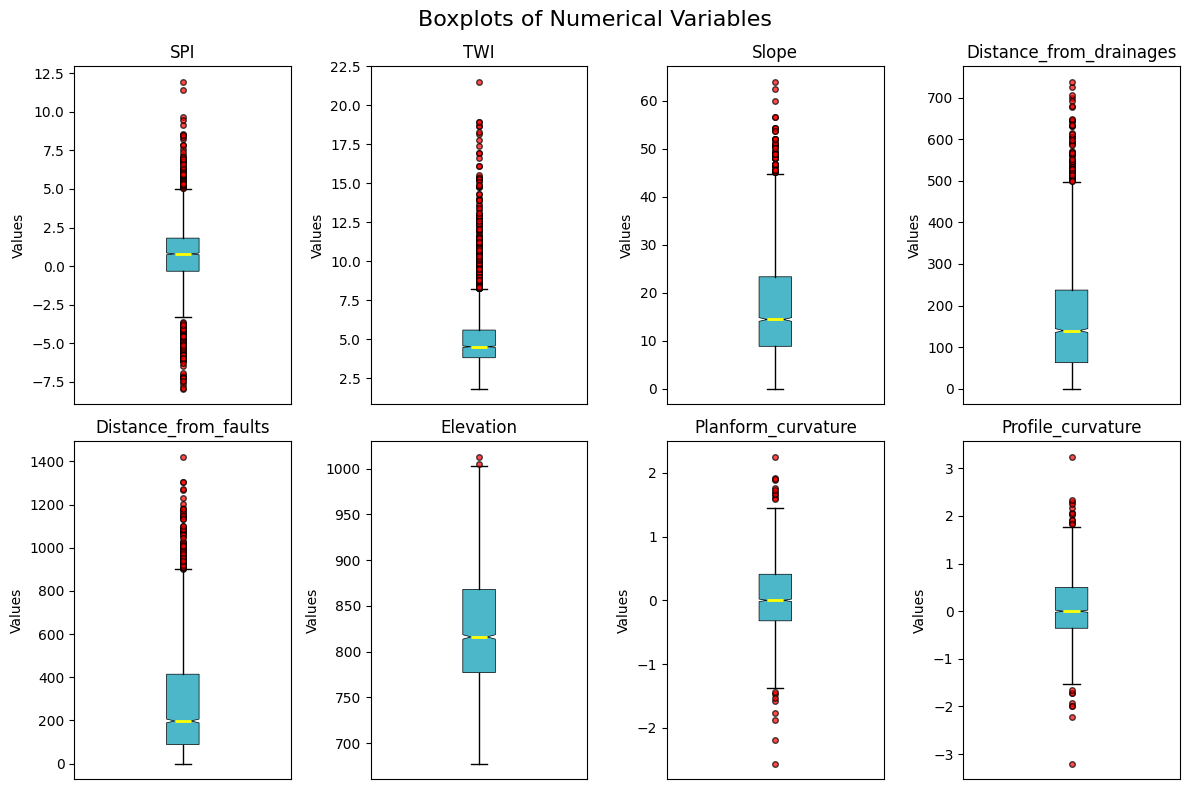

In [55]:
# Select only numeric columns specified in numerical_features
data_num = X[X.columns[numerical_features]]

# Number of variables per line
vars_per_row = 4

# Calculate the number of lines
num_rows = (len(data_num.columns) - 1) // vars_per_row + 1

# Create a figure with subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=vars_per_row, figsize=(12, 8))

# Flatten the axis matrix to facilitate iteration
axes = axes.flatten()

# Create a boxplot for each variable and add it to the corresponding subplot
for i, column in enumerate(data_num):
 ax = axes[i] # Select the correct axis
 ax.boxplot(data_num[column], patch_artist=True, notch=True,
 flierprops=dict(alpha=0.7, marker='o', markersize=4, markerfacecolor='red', markeredgecolor='black'),
 boxprops=dict(linewidth=0.5, facecolor=(0, 0.6, 0.7, 0.7)),
 medianprops=dict(color='yellow', linewidth=2),
 whiskerprops=dict(color='black', linewidth=1))
 ax.set_title('{}'.format(column)) # Chart title
 ax.set_ylabel('Values') # Y-axis label
 ax.set_xticklabels([]) # Remove x-axis labels
 ax.set_xticks([]) # Remove lines from x axis

# Remove unused subplots
for i in range(len(data_num.columns), num_rows * vars_per_row):
 fig.delaxes(axes[i])

# Add title to figure
fig.suptitle('Boxplots of Numerical Variables', fontsize=16)

plt.tight_layout() # Adjust layout to avoid overlapping
plt.show() # Display the boxplots in two lines, I want to leave only the y axis line (values) showing

In [56]:
data_num.head()

,SPI,TWI,Slope,Distance_from_drainages,Distance_from_faults,Elevation,Planform_curvature,Profile_curvature
0,0.786968,3.368280,28.844410,353.995056,300.520386,913.0,-0.147692,-0.147692
1,1.090638,4.449178,20.000000,215.783456,55.901699,915.0,-0.563200,0.076800
2,0.544214,3.610038,21.540659,162.980060,95.197166,924.0,0.088276,-0.551724
3,3.340890,7.474503,12.600483,70.710678,185.825867,730.0,-0.639627,0.648576
4,0.011858,4.139150,12.649111,0.000000,67.314560,765.0,0.640000,-0.640000


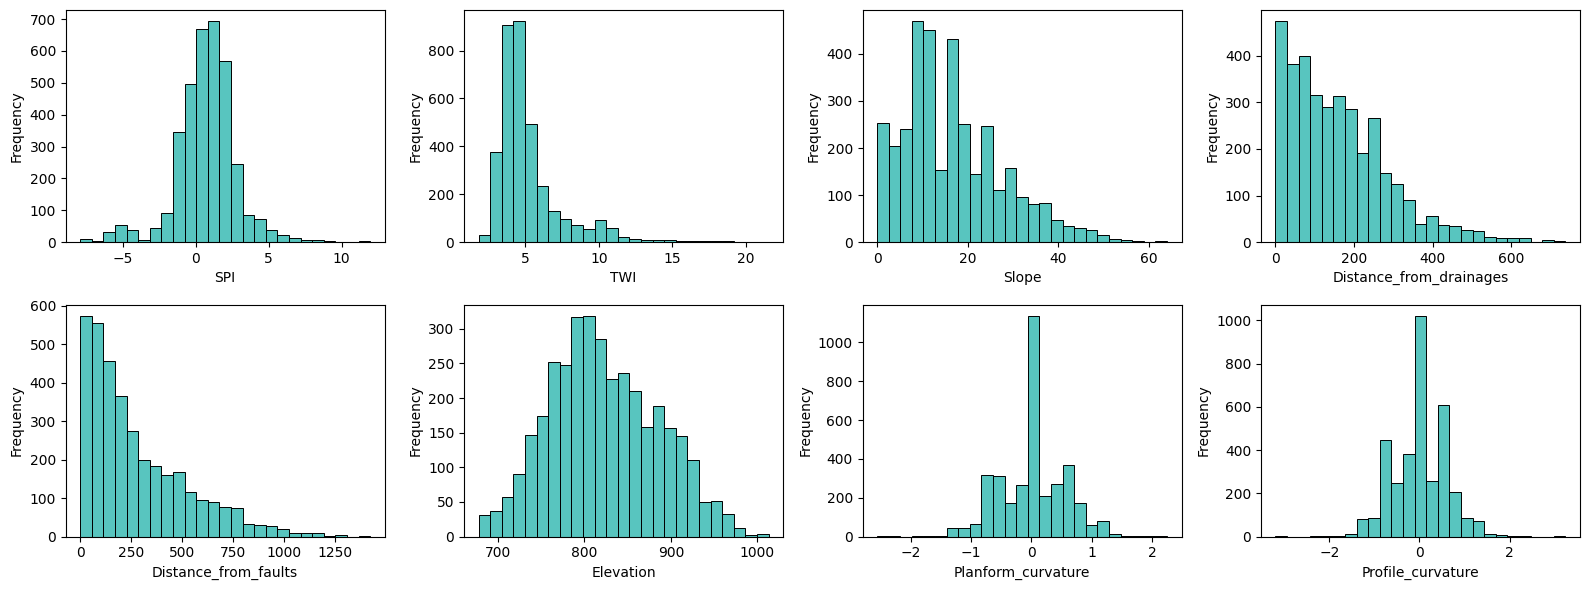

In [57]:
# Filter NaN values ​​before plotting histograms
data_num_no_nan = data_num.dropna(subset=data_num.columns[data_num.columns != 'Target'], how='any')

# Number of columns and lines of subplots
num_cols = 4
num_rows = int(np.ceil(len(data_num_no_nan.columns) / num_cols))

# Plot histograms in subplots
plt.figure(figsize=(16, 6))
for i, column in enumerate(data_num_no_nan.columns):
  if column != 'Target':
    plt.subplot(num_rows, num_cols, i+1)
    sns.histplot(data_num_no_nan[column], bins=25, color='lightseagreen')
    ax.set_xticklabels([]) # Remove x-axis labels
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

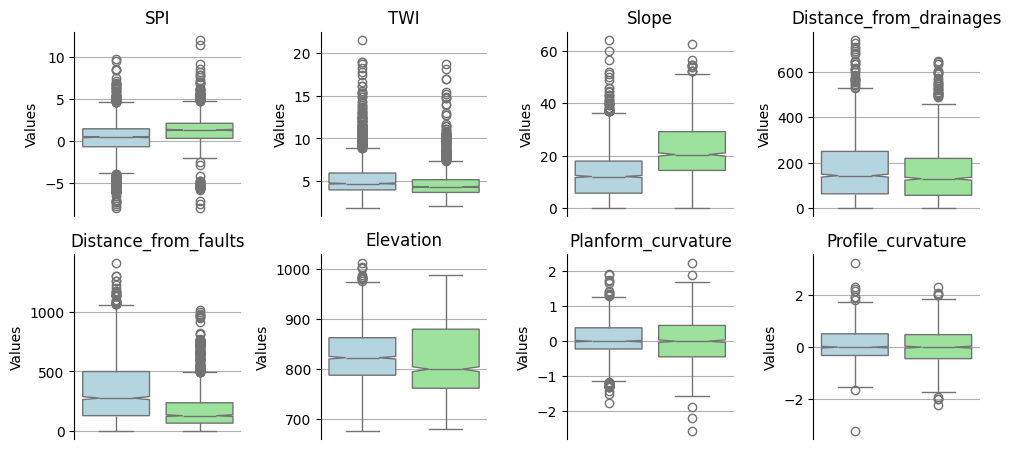

In [58]:
# Define numerical column indices and the target column name
numerical_indices = [0, 1, 2, 3, 4, 5, 8, 9]
numerical_columns = [df.columns[i] for i in numerical_indices]
target_column = df.columns[10]

# Number of variables per row
vars_per_row = 4

# Calculate number of rows needed
num_rows = (len(numerical_columns) - 1) // vars_per_row + 1

# Create a figure with subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=vars_per_row, figsize=(10,5))

# Flatten the axes matrix for easier iteration
axes = axes.flatten()

# Create a boxplot for each variable and add to the corresponding subplot
for i, column in enumerate(numerical_columns):
    ax = axes[i]  # Select the correct axis
    sns.boxplot(x=target_column, y=column, data=df, ax=ax, notch=True,
                palette={'0': 'lightblue', '1': 'lightgreen'})
    ax.set_title(f'{column}')  # Title of the plot
    ax.set_ylabel('Values')  # Y-axis label
    ax.set_xlabel('')  # Remove x-axis label
    ax.xaxis.set_visible(False)  # Hide x-axis line
    ax.spines['top'].set_visible(False)  # Hide top border
    ax.spines['right'].set_visible(False)  # Hide right border
    ax.spines['bottom'].set_visible(False)  # Hide bottom border
    ax.spines['left'].set_visible(True)  # Show left border
    ax.yaxis.grid(True)  # Add gridlines to y-axis

# Remove unused subplots
for i in range(len(numerical_columns), num_rows * vars_per_row):
    fig.delaxes(axes[i])

# Add a title to the figure
#fig.suptitle('Boxplots of Numerical Variables by Target', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to avoid overlap and leave space for the title
plt.show()

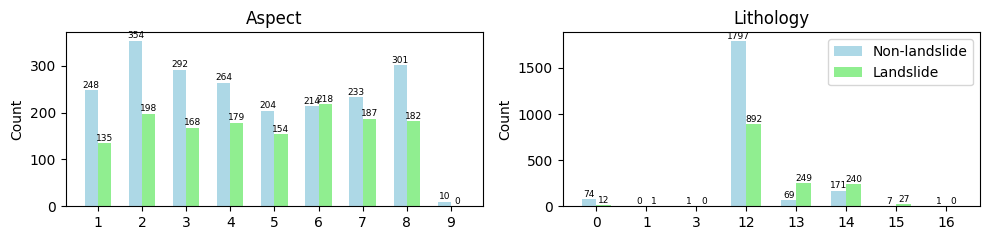

In [59]:
# Counting for Aspect
aspect_counts = df.groupby(['Aspect', 'Target']).size().unstack(fill_value=0)

# Counting for Lithology
litho_counts = df.groupby(['Lithology', 'Target']).size().unstack(fill_value=0)

# Setting the figure size
plt.figure(figsize=(10, 2.5))

# Bar plot for Aspect
plt.subplot(1, 2, 1)  # Subplot for Aspect
bar_width = 0.3
labels_aspect = aspect_counts.index
x_aspect = np.arange(len(labels_aspect))

bars0_aspect = plt.bar(x_aspect - bar_width/2, aspect_counts[0], width=bar_width, label='Non-landslide', color='lightblue')
bars1_aspect = plt.bar(x_aspect + bar_width/2, aspect_counts[1], width=bar_width, label='Landslide', color='lightgreen')

plt.title('Aspect')
plt.ylabel('Count')
plt.xticks(x_aspect, labels_aspect)
#plt.legend()

# Adding counts above the bars in the Aspect plot
for bar in bars0_aspect + bars1_aspect:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{int(yval)}', ha='center', va='bottom', color='black', fontsize=6.5)

# Bar plot for Lithology
plt.subplot(1, 2, 2)  # Subplot for Lithology
bar_width = 0.3
labels_litho = litho_counts.index
x_litho = np.arange(len(labels_litho))

bars0_litho = plt.bar(x_litho - bar_width/2, litho_counts[0], width=bar_width, label='Non-landslide', color='lightblue')
bars1_litho = plt.bar(x_litho + bar_width/2, litho_counts[1], width=bar_width, label='Landslide', color='lightgreen')

plt.title('Lithology')
plt.ylabel('Count')
plt.xticks(x_litho, labels_litho)
plt.legend()

# Adding counts above the bars in the Lithology plot
for bar in bars0_litho + bars1_litho:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{int(yval)}', ha='center', va='bottom', color='black', fontsize=6.5)
# Adjusting layout and displaying the plots
plt.tight_layout()
plt.show()


In [60]:
# Calculation of descriptive statistics
stats2 = df.groupby(target_column)[numerical_columns].agg(['mean', 'std', 'var'])

# Print the descriptive statistics
print(stats2)

             SPI                           TWI                          Slope  \
            mean       std       var      mean       std       var       mean   
Target                                                                          
0       0.339309  2.084477  4.345044  5.413346  2.304392  5.310221  13.165634   
1       1.232860  1.886631  3.559378  4.817701  1.980829  3.923685  22.112182   

                              Distance_from_drainages  ...  \
              std         var                    mean  ...   
Target                                                 ...   
0        9.279790   86.114502              169.238337  ...   
1       11.812062  139.524811              149.019213  ...   

       Distance_from_faults   Elevation                         \
                        var        mean       std          var   
Target                                                           
0              68243.572449  826.518562  59.25089  3510.667967   
1              3470

In [61]:
# Descriptive statistics for categorical variables

# Count for Aspect
aspect_counts = df.groupby(['Aspect', target_column]).size().unstack(fill_value=0)
aspect_freq = df['Aspect'].value_counts(normalize=True).rename('frequency')

# Count for Lithology
litho_counts = df.groupby(['Lithology', target_column]).size().unstack(fill_value=0)
litho_freq = df['Lithology'].value_counts(normalize=True).rename('frequency')

# Print the categorical descriptive statistics
print("\nCount of Aspect by Target:")
print(aspect_counts)
print("\nRelative frequency of Aspect:")
print(aspect_freq)

print("\nCount of Lithology by Target:")
print(litho_counts)
print("\nRelative frequency of Lithology:")
print(litho_freq)


Count of Aspect by Target:
Target    0    1
Aspect          
1       248  135
2       354  198
3       292  168
4       264  179
5       204  154
6       214  218
7       233  187
8       301  182
9        10    0

Relative frequency of Aspect:
Aspect
2    0.155888
8    0.136402
3    0.129907
4    0.125106
6    0.121999
7    0.118611
1    0.108162
5    0.101101
9    0.002824
Name: frequency, dtype: float64

Count of Lithology by Target:
Target        0    1
Lithology           
0            74   12
1             0    1
3             1    0
12         1797  892
13           69  249
14          171  240
15            7   27
16            1    0

Relative frequency of Lithology:
Lithology
12    0.759390
14    0.116069
13    0.089805
0     0.024287
15    0.009602
1     0.000282
3     0.000282
16    0.000282
Name: frequency, dtype: float64


In [62]:
df.columns

Index(['SPI', 'TWI', 'Slope', 'Distance_from_drainages',
       'Distance_from_faults', 'Elevation', 'Lithology', 'Aspect',
       'Planform_curvature', 'Profile_curvature', 'Target'],
      dtype='object')

In [63]:
# Calculate the statistics
stats = pd.DataFrame({
    'Number of Data Points': df.count(),
    'Missing Data': df.isnull().sum(),
    'Mean': df.mean(),
    'Standard Deviation': df.std(),
    'Variance': df.var(),
    'Minimum Value': df.min(),
    '1st Quartile': df.quantile(0.25),
    'Median': df.median(),
    '3rd Quartile': df.quantile(0.75),
    'Maximum Value': df.max(),
    'Mode': df.mode().iloc[0],
    'Mode Frequency': df.apply(lambda x: x.value_counts().max())
})

# Display the statistics table
stats

,Number of Data Points,Missing Data,Mean,Standard Deviation,Variance,Minimum Value,1st Quartile,Median,3rd Quartile,Maximum Value,Mode,Mode Frequency
SPI,3541,0,0.697890,2.054397,4.220546,-7.949280,-0.334715,0.791259,1.813289,11.958579,-1.027863,34
TWI,3541,0,5.174314,2.199501,4.837806,1.846618,3.827874,4.536247,5.602837,21.523087,3.789333,33
Slope,3541,0,16.755875,11.258353,126.750518,0.000000,8.829022,14.422205,23.323807,64.000000,8.944272,222
Distance_from_drainages,3541,0,161.124422,125.363813,15716.085675,0.000000,62.500000,139.754249,237.170825,738.664335,12.500000,166
Distance_from_faults,3541,0,277.316583,244.848563,59950.818614,0.000000,88.388351,197.642349,414.201050,1421.486938,12.500000,99
Elevation,3541,0,822.460568,62.716101,3933.309359,677.487732,777.000000,816.000000,868.000000,1013.000000,807.000000,32
Lithology,3541,0,12.054787,2.048795,4.197563,0.000000,12.000000,12.000000,12.000000,16.000000,12.000000,2689
Aspect,3541,0,4.494493,2.322400,5.393543,1.000000,2.000000,4.000000,7.000000,9.000000,2.000000,552
Planform_curvature,3541,0,0.021468,0.539444,0.291000,-2.560000,-0.321494,0.000000,0.408276,2.251034,0.000000,716
Profile_curvature,3541,0,0.033703,0.591400,0.349754,-3.200000,-0.357647,0.000000,0.498824,3.244056,0.000000,510


Importing packages for Machine Learning

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

In [65]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories='auto', handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)])

In [66]:
X[:3]

,SPI,TWI,Slope,Distance_from_drainages,Distance_from_faults,Elevation,Lithology,Aspect,Planform_curvature,Profile_curvature
0,0.786968,3.368280,28.844410,353.995056,300.520386,913.0,13,4,-0.147692,-0.147692
1,1.090638,4.449178,20.000000,215.783456,55.901699,915.0,13,8,-0.563200,0.076800
2,0.544214,3.610038,21.540659,162.980060,95.197166,924.0,13,7,0.088276,-0.551724


In [67]:
y = df["Target"]

In [68]:
y[:]

,Target
0,1
1,1
2,1
3,1
4,1
...,...
3537,0
3538,0
3539,0
3540,0


Splitting our data into a training set (70% of the data) and a test set (30%), stratified after classes, to obtain the same amount of landslide and non-landslide samples in both sets. Random_sate= 42 for reproducibility

In [69]:
from sklearn.model_selection import train_test_split

# Splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [70]:
# Indices of training and test rows in X
train_indices = X_train.index
test_indices = X_test.index

# Selecting corresponding data in df
df_train = df.loc[train_indices]
df_test = df.loc[test_indices]

print("Training Data:")
print(df_train)
print("\Test Data:")
print(df_test)

Training Data:
           SPI       TWI      Slope  Distance_from_drainages  \
871   0.628321  4.335111  16.970562                45.069391   
810   0.019610  2.749064  24.331051               233.519271   
24   -0.082437  2.850692  24.000000                27.950850   
3096  0.740969  6.409055   5.648057                27.950850   
3407  0.741529  4.222584  17.888544                88.388348   
...        ...       ...        ...                      ...   
3423 -1.721010  4.471484   5.656854                95.197164   
2198  1.082810  4.901905  14.422205               125.623445   
2177 -1.015516  3.777122   8.000000               203.485257   
2336  0.336064  3.817119  17.888544               215.058132   
1753 -1.262864  4.021410   8.000000               221.147575   

      Distance_from_faults   Elevation  Lithology  Aspect  Planform_curvature  \
871              55.901699  928.000000         13       8           -0.640000   
810              70.710678  761.000000         12     

In [71]:
# Count of classes in the training set
counts = np.bincount(y)
print("Distribution of classes in the total set:")
print(f"Target 0: {counts[0]} examples")
print(f"Target 1: {counts[1]} examples")

# Count of classes in the training set
counts_train = np.bincount(y_train)
print("\nDistribution of classes in the training set:")
print(f"Target 0: {counts_train[0]} examples")
print(f"Target: {counts_train[1]} examples")

# Count of classes in the test suite
counts_test = np.bincount(y_test)
print("\nDistribution of classes in the test set:")
print(f"Target 0: {counts_test[0]} examples")
print(f"Target 1: {counts_test[1]} examples")

Distribution of classes in the total set:
Target 0: 2120 examples
Target 1: 1421 examples

Distribution of classes in the training set:
Target 0: 1484 examples
Target: 994 examples

Distribution of classes in the test set:
Target 0: 636 examples
Target 1: 427 examples


Checking the number of points in testing and training data

In [72]:
X_train.shape

(2478, 10)

In [73]:
X_train[:3]

,SPI,TWI,Slope,Distance_from_drainages,Distance_from_faults,Elevation,Lithology,Aspect,Planform_curvature,Profile_curvature
871,0.628321,4.335111,16.970562,45.069391,55.901699,928.0,13,8,-0.640000,0.640000
810,0.019610,2.749064,24.331051,233.519271,70.710678,761.0,12,7,0.882162,0.242162
24,-0.082437,2.850692,24.000000,27.950850,510.055145,904.0,12,1,0.000000,0.000000


In [74]:
X_test.shape

(1063, 10)

In [75]:
X_test[:3]

,SPI,TWI,Slope,Distance_from_drainages,Distance_from_faults,Elevation,Lithology,Aspect,Planform_curvature,Profile_curvature
2106,1.778654,4.573410,25.266260,137.500000,174.104858,738.000000,12,1,-1.183834,1.381556
3179,-0.194009,4.343226,8.944272,97.628121,35.355339,762.000000,12,4,-0.640000,0.000000
1640,0.114910,7.227812,5.626816,440.347874,654.909363,823.003113,12,6,-0.958418,0.320410


In [76]:
X_train.describe()

,SPI,TWI,Slope,Distance_from_drainages,Distance_from_faults,Elevation,Lithology,Aspect,Planform_curvature,Profile_curvature
count,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000
mean,0.696418,5.163216,16.786494,163.995150,276.530313,822.847561,12.041969,4.479822,0.019044,0.035470
std,2.043601,2.159529,11.158861,126.043081,244.872298,63.107668,2.098852,2.329749,0.541634,0.593820
min,-7.949280,2.038300,0.000000,0.000000,0.000000,677.511902,0.000000,1.000000,-2.189241,-3.200000
25%,-0.334715,3.827874,8.877835,62.500000,88.388351,777.012451,12.000000,2.000000,-0.323986,-0.358601
50%,0.784301,4.537798,14.422205,139.754249,197.642349,817.000000,12.000000,4.000000,0.000000,0.000000
75%,1.830405,5.608145,23.323807,237.746540,412.642021,868.000000,12.000000,7.000000,0.409269,0.528123
max,9.488705,21.523087,62.481998,738.664335,1421.486938,1013.000000,16.000000,9.000000,2.251034,2.327551


# Visualizing training and testing data

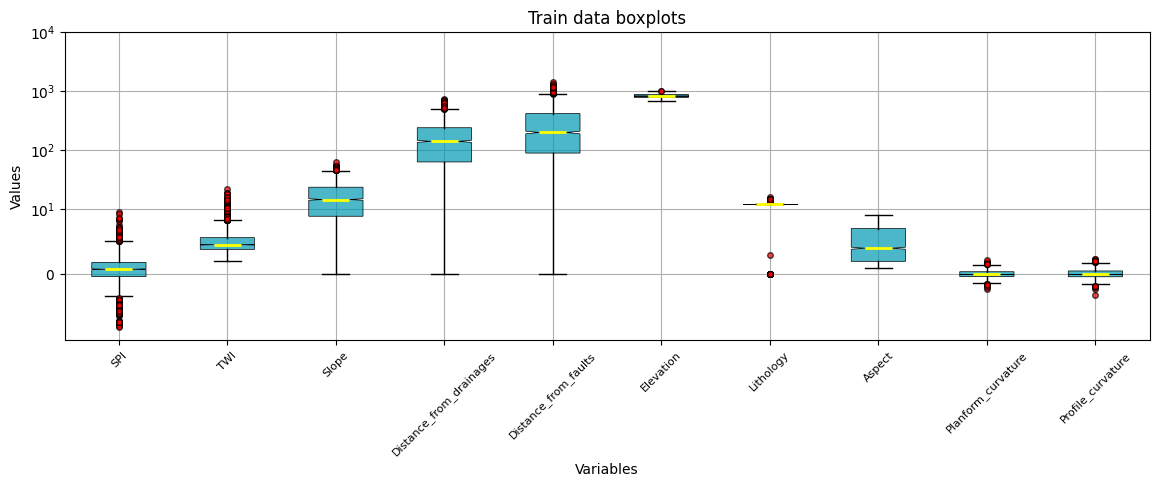

In [77]:
# Create boxplots for each column of the DataFrame
boxplot_train = X_train.boxplot(patch_artist=True, notch=True, flierprops=dict(alpha=0.7,marker='o', markersize=4, markerfacecolor='red', markeredgecolor='black'),
 boxprops=dict(linewidth=0.5, facecolor=(0, 0.6, 0.7, 0.7)), medianprops=dict(color='yellow', linewidth=2),
 whiskerprops=dict(color='black', linewidth=1), grid=dict(alpha=0.7, color='gray', linewidth=0.1))

# Configure axis title and labels
plt.title('Train data boxplots')
plt.xlabel('Variables')
plt.ylabel('Values')

# Increase the spacing between variables on the x-axis and decrease the font size
plt.xticks(rotation=45, fontsize=8)

# Configure the x-axis size
plt.gcf().set_size_inches(14, 4) # Adjust values ​​(width, height) as needed

# Configure the y-axis in logarithmic scale
plt.yscale('symlog', linthresh=10, linscale=1)

# Set y-axis limits
plt.ylim(-10, 10000)

# Display the graph
plt.show()

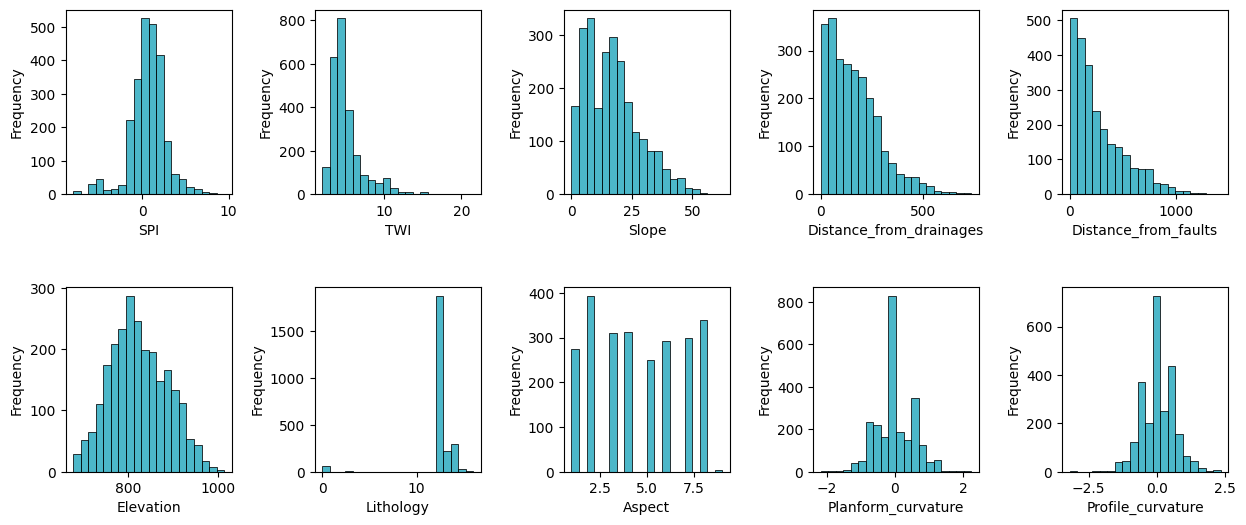

In [78]:
# Set the number of subplots per line
subplots_per_row = 5

# Calculate the number of lines needed
num_rows = (len(X_train.columns) + subplots_per_row - 1) // subplots_per_row

# Create histograms for each variable in X_train
fig, axs = plt.subplots(nrows=num_rows, ncols=subplots_per_row, figsize=(15, 3*num_rows))

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# Create histograms
for i, column in enumerate(X_train.columns):
 ax = axs[i // subplots_per_row, i % subplots_per_row]
 sns.histplot(X_train[column], bins=20, facecolor=(0, 0.6, 0.7, 0.7), ax=ax, alpha = 0.7)
 ax.set_ylabel('Frequency')

# Remove empty subplots, if any
for i in range(len(X_train.columns), num_rows*subplots_per_row):
 fig.delaxes(axs.flatten()[i])

plt.show()

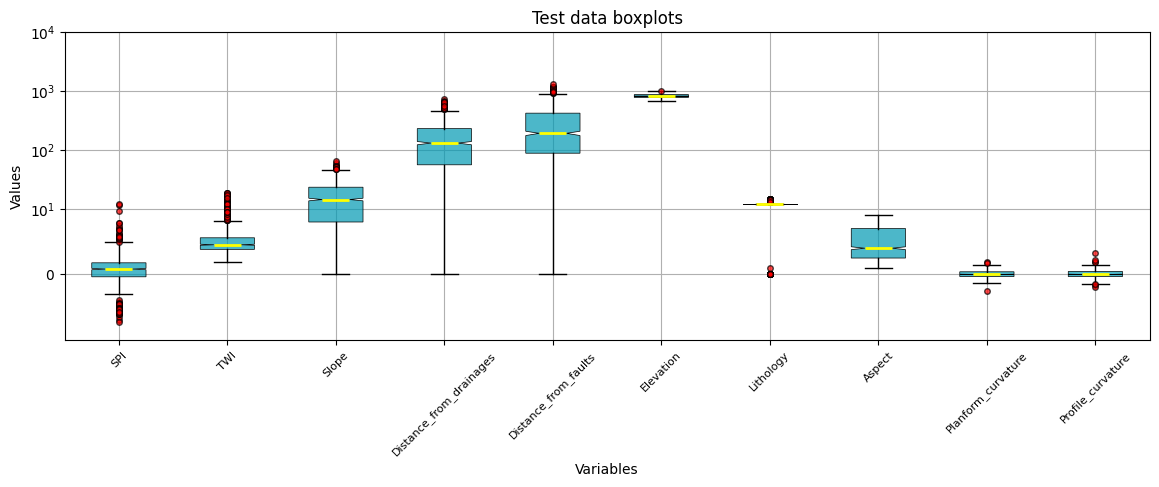

In [79]:
# Create boxplots for each column of the DataFrame
boxplot_test = X_test.boxplot(patch_artist=True, notch=True, flierprops=dict(alpha=0.7,marker='o', markersize=4, markerfacecolor='red', markeredgecolor='black'),
 boxprops=dict(linewidth=0.5, facecolor=(0, 0.6, 0.7, 0.7)), medianprops=dict(color='yellow', linewidth=2),
 whiskerprops=dict(color='black', linewidth=1), grid=dict(alpha=0.7, color='gray', linewidth=0.1))

# Configure axis title and labels
plt.title('Test data boxplots')
plt.xlabel('Variables')
plt.ylabel('Values')

# Increase the spacing between variables on the x-axis and decrease the font size
plt.xticks(rotation=45, fontsize=8)

# Configure the x-axis size
plt.gcf().set_size_inches(14, 4) # Adjust values ​​(width, height) as needed
# Configure the y-axis in logarithmic scale
plt.yscale('symlog', linthresh=10, linscale=1)

# Set y-axis limits
plt.ylim(-10, 10000)

# Display the graph
plt.show()

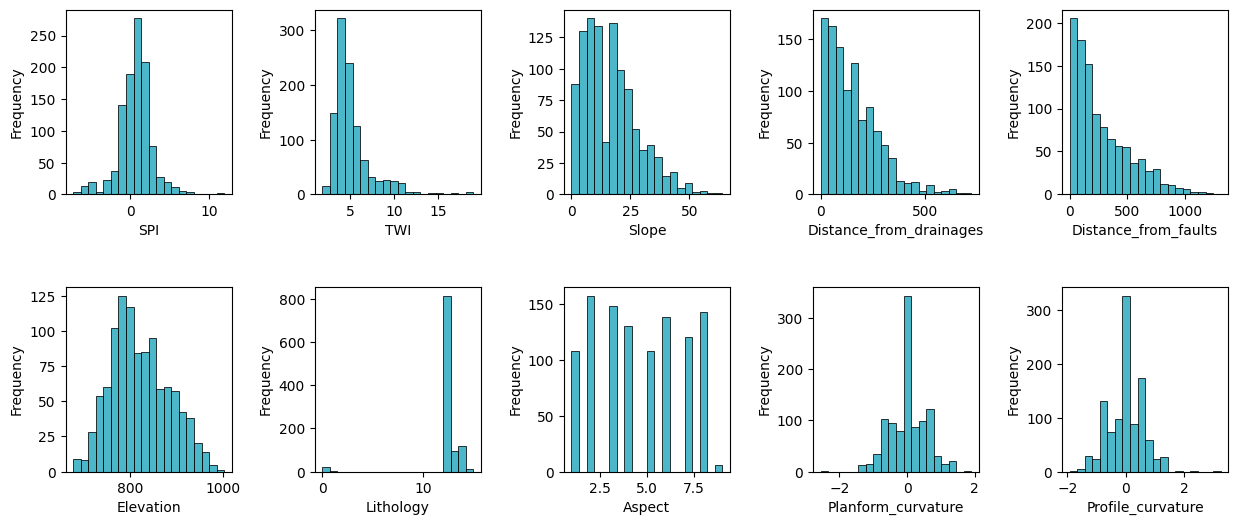

In [80]:
# Set the number of subplots per line
subplots_per_row = 5

# Calculate the number of lines needed
num_rows = (len(X_test.columns) + subplots_per_row - 1) // subplots_per_row

# Create histograms for each variable in X_test
fig, axs = plt.subplots(nrows=num_rows, ncols=subplots_per_row, figsize=(15, 3*num_rows))

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# Create histograms
for i, column in enumerate(X_test.columns):
 ax = axs[i // subplots_per_row, i % subplots_per_row]
 sns.histplot(X_test[column], bins=20, facecolor=(0, 0.6, 0.7, 0.7), ax=ax, alpha = 0.7)
 ax.set_ylabel('Frequency')

# Remove empty subplots, if any
for i in range(len(X_test.columns), num_rows*subplots_per_row):
 fig.delaxes(axs.flatten()[i])

plt.show()

# Artificial neural networks (ANN)

In [81]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer, accuracy_score, cohen_kappa_score, classification_report
from sklearn.model_selection import cross_validate, KFold, GridSearchCV
from sklearn.datasets import load_digits

In [82]:
'''
# Set the parameters for grid search
# Note: Divide the grid search into more parts if it is too complex

grid_ann = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100), (100, 100, 100), (20,100), (20,30,100), (7), (10), (11), (12), (13), (15),(16), (18),  (22), (23), (25), (21),(26), (27), (28) ,(29), (33), (34), (35), (36)],
    'classifier__activation': ['relu', 'tanh', 'logistic'],
    'classifier__alpha': [0.0001, 0.00001, 0.000001],
    'classifier__solver': ['adam', 'sgd'],
    'classifier__verbose': [True],
}
'''

"\n# Set the parameters for grid search\n# Note: Divide the grid search into more parts if it is too complex\n\ngrid_ann = {\n    'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100), (100, 100, 100), (20,100), (20,30,100), (7), (10), (11), (12), (13), (15),(16), (18),  (22), (23), (25), (21),(26), (27), (28) ,(29), (33), (34), (35), (36)],\n    'classifier__activation': ['relu', 'tanh', 'logistic'],\n    'classifier__alpha': [0.0001, 0.00001, 0.000001],\n    'classifier__solver': ['adam', 'sgd'],\n    'classifier__verbose': [True],\n}\n"

In [83]:
# Fit the ColumnTransformer to your data
preprocessor.fit(X_train)

# Transform the training data
X_train_transformed = preprocessor.transform(X_train)

# Get the names of columns after transformation
transformed_columns = preprocessor.get_feature_names_out()

# Get the number of columns after transformation
num_columns_transformed = X_train_transformed.shape[1]

# Display the number of columns after transformation
print("Number of columns after transformation:", num_columns_transformed)

# Display the names of transformed columns
print("Names of columns after transformation:")
print(transformed_columns)

# Fit the ColumnTransformer to your test data
preprocessor.fit(X_test)

# Transform the test data
X_test_transformed = preprocessor.transform(X_test)

# Get the names of columns after transformation for test data
transformed_columns_test = preprocessor.get_feature_names_out()

# Get the number of columns after transformation for test data
num_columns_transformed_test = X_test_transformed.shape[1]

# Display the number of columns after transformation for test data
print("Number of columns after transformation (test data):", num_columns_transformed_test)

# Display the names of transformed columns for test data
print("Names of columns after transformation (test data):")
print(transformed_columns_test)

Number of columns after transformation: 24
Names of columns after transformation:
['cat__Lithology_0' 'cat__Lithology_3' 'cat__Lithology_12'
 'cat__Lithology_13' 'cat__Lithology_14' 'cat__Lithology_15'
 'cat__Lithology_16' 'cat__Aspect_1' 'cat__Aspect_2' 'cat__Aspect_3'
 'cat__Aspect_4' 'cat__Aspect_5' 'cat__Aspect_6' 'cat__Aspect_7'
 'cat__Aspect_8' 'cat__Aspect_9' 'num__SPI' 'num__TWI' 'num__Slope'
 'num__Distance_from_drainages' 'num__Distance_from_faults'
 'num__Elevation' 'num__Planform_curvature' 'num__Profile_curvature']
Number of columns after transformation (test data): 23
Names of columns after transformation (test data):
['cat__Lithology_0' 'cat__Lithology_1' 'cat__Lithology_12'
 'cat__Lithology_13' 'cat__Lithology_14' 'cat__Lithology_15'
 'cat__Aspect_1' 'cat__Aspect_2' 'cat__Aspect_3' 'cat__Aspect_4'
 'cat__Aspect_5' 'cat__Aspect_6' 'cat__Aspect_7' 'cat__Aspect_8'
 'cat__Aspect_9' 'num__SPI' 'num__TWI' 'num__Slope'
 'num__Distance_from_drainages' 'num__Distance_from_faults

In [84]:
# Create a base classifier
base_ann = MLPClassifier(max_iter=1500, verbose=True, tol=0.0001, random_state=42)

"Pipeline" is for making workflow with standardization and classification in a few lines of code

In [85]:
# Create the model pipeline
ann_flow = Pipeline([
    ('preproc', preprocessor),
    ('classifier', base_ann)
])

In [86]:
# Define the acc_scorer metric
acc_scorer = make_scorer(accuracy_score)

In [87]:
# Initialize KFold cross-validation with 10 folds, shuffling data, and setting random state to 42
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [88]:
# Grid search parameters defined for the model
grid_ann = {
    'classifier__hidden_layer_sizes': [(28,)],  # Single hidden layer with 28 neurons
    'classifier__activation': ['relu'],         # Activation function ReLU
    'classifier__alpha': [0.1],                 # Regularization parameter alpha
    'classifier__solver': ['adam'],             # Optimizer solver Adam
}

In [89]:
model_ann = GridSearchCV(ann_flow, param_grid = grid_ann, cv = kfold, scoring=acc_scorer)

In [90]:
model_ann.fit(X_train, y_train)

A saída de streaming foi truncada nas últimas 5000 linhas.
Iteration 273, loss = 0.45486156
Iteration 274, loss = 0.45476564
Iteration 275, loss = 0.45448158
Iteration 276, loss = 0.45438610
Iteration 277, loss = 0.45416168
Iteration 278, loss = 0.45383908
Iteration 279, loss = 0.45437351
Iteration 280, loss = 0.45399578
Iteration 281, loss = 0.45374476
Iteration 282, loss = 0.45359795
Iteration 283, loss = 0.45392025
Iteration 284, loss = 0.45385389
Iteration 285, loss = 0.45331999
Iteration 286, loss = 0.45324830
Iteration 287, loss = 0.45356632
Iteration 288, loss = 0.45321825
Iteration 289, loss = 0.45285671
Iteration 290, loss = 0.45301105
Iteration 291, loss = 0.45272829
Iteration 292, loss = 0.45225722
Iteration 293, loss = 0.45235706
Iteration 294, loss = 0.45233126
Iteration 295, loss = 0.45242477
Iteration 296, loss = 0.45205660
Iteration 297, loss = 0.45249250
Iteration 298, loss = 0.45223535
Iteration 299, loss = 0.45196273
Iteration 300, loss = 0.45180913
Iteration 301, lo

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         [6,
                                                                          7]),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          8,
                                                                          9])])),
                                       ('classifier',
                                        MLPClassifier(max_iter=1500,
                                                      random_state=42,
                                                      verbose=True))]),
             param_grid={'classifier__activation': ['relu'],
                         'classifier__alpha': [0.1],
                         'classifier__hidden_layer_sizes': [(28,)],
                         'classifier__solver': ['adam']},
             scoring=make_scorer(accuracy_score, response_method='predict'))

In [91]:
print(model_ann.best_params_)
# Print the best cross-validation score
best_score_ann = model_ann.best_score_
print(f"\nBest Cross-Validation Score: {best_score_ann}")

{'classifier__activation': 'relu', 'classifier__alpha': 0.1, 'classifier__hidden_layer_sizes': (28,), 'classifier__solver': 'adam'}

Best Cross-Validation Score: 0.7396989682643333


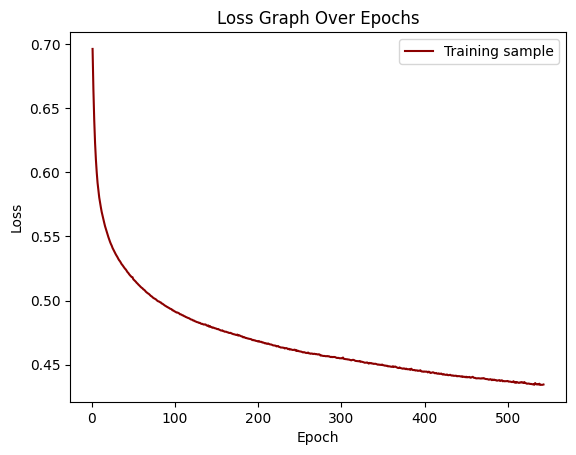

In [92]:
# Accessing the best GridSearchCV model
best_model = model_ann.best_estimator_

# Accessing loss history
historico_perda = best_model.named_steps['classifier'].loss_curve_

# Plotting the loss graph
plt.plot(np.arange(1, len(historico_perda) + 1), historico_perda, label='Training sample', color='darkred')
plt.title('Loss Graph Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [93]:
from sklearn.metrics import accuracy_score

# Make predictions using the model
y_pred_ann = model_ann.predict(X_test)

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred_ann)
print(f"Overall accuracy: {overall_accuracy * 100:.2f}%")

# Calculate accuracy for class 0
accuracy_class_0 = accuracy_score(y_test[y_test == 0], y_pred_ann[y_test == 0])
print(f"Accuracy for class 0: {accuracy_class_0 * 100:.2f}%")

# Calculate accuracy for class 1
accuracy_class_1 = accuracy_score(y_test[y_test == 1], y_pred_ann[y_test == 1])
print(f"Accuracy for class 1: {accuracy_class_1 * 100:.2f}%")

Overall accuracy: 75.82%
Accuracy for class 0: 83.65%
Accuracy for class 1: 64.17%


In [94]:
# Perform predictions on the training dataset using the trained artificial neural network model.
y_pred_ann_train = model_ann.predict(X_train)

In [95]:
# Calculate evaluation metrics

print("Evaluation metrics for ANN:")
print("Accuracy (Test)/Overall Accuracy:", accuracy_score(y_test, y_pred_ann))
print("Accuracy (Training):", accuracy_score(y_train, y_pred_ann_train))

print("Cohen's Kappa Score:", cohen_kappa_score(y_test, y_pred_ann))

print(classification_report(y_test, y_pred_ann, target_names=['non-landslide', 'landslide']))

Evaluation metrics for ANN:
Accuracy (Test)/Overall Accuracy: 0.7582314205079962
Accuracy (Training): 0.817998385794996
Cohen's Kappa Score: 0.4873532331399898
               precision    recall  f1-score   support

non-landslide       0.78      0.84      0.81       636
    landslide       0.72      0.64      0.68       427

     accuracy                           0.76      1063
    macro avg       0.75      0.74      0.74      1063
 weighted avg       0.76      0.76      0.76      1063



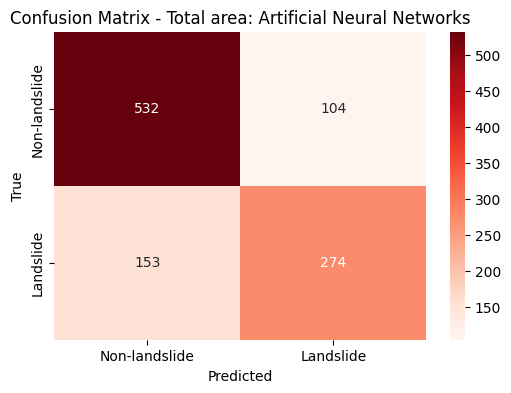

In [96]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_ann)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix - Total area: Artificial Neural Networks')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0.5, 1.5], ['Non-landslide', 'Landslide'])
plt.yticks([0.5, 1.5], ['Non-landslide', 'Landslide'])
plt.show()

In [97]:
# Calculate metrics
overall_accuracy = accuracy_score(y_test, y_pred_ann)
kappa = cohen_kappa_score(y_test, y_pred_ann)

# Extract values from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate Sensitivity and Specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print results
print(f'Overall Accuracy: {overall_accuracy:.4f}')
print(f'Kappa: {kappa:.4f}')
print(f'Sensitivity ANN: {sensitivity:.4f}')
print(f'Specificity ANN: {specificity:.4f}')

Overall Accuracy: 0.7582
Kappa: 0.4874
Sensitivity ANN: 0.6417
Specificity ANN: 0.8365


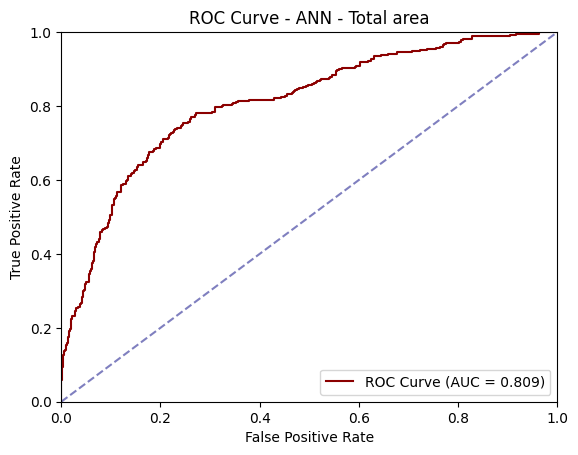

In [98]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_pred_proba_ann = model_ann.predict_proba(X_test)[:, 1]

# Calculate false positive rate and true positive rate
fpr_ann, tpr_ann, thresholds = roc_curve(y_test, y_pred_proba_ann)

# Calculate area under the ROC curve
roc_auc_ann = auc(fpr_ann, tpr_ann)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_ann, tpr_ann, color='darkred', lw=1.5, label='ROC Curve (AUC = %0.3f)' % roc_auc_ann)
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - ANN - Total area')
plt.legend(loc="lower right")
plt.show()

In [99]:
# Find indices where the model misclassified class 0
error_indices_class_0 = np.where((y_test == 0) & (y_pred_ann != 0))[0]

# Examine features of misclassified examples in class 0
misclassified_examples_class_0 = X_test.iloc[error_indices_class_0, :]

# Find indices where the model misclassified class 1
error_indices_class_1 = np.where((y_test == 1) & (y_pred_ann != 1))[0]

# Examine features of misclassified examples in class 1
misclassified_examples_class_1 = X_test.iloc[error_indices_class_1, :]

# Calculate the number of errors in class 0
num_errors_class_0 = misclassified_examples_class_0.shape[0]
print("Number of errors in class 0:", num_errors_class_0)

# Calculate the number of errors in class 1
num_errors_class_1 = misclassified_examples_class_1.shape[0]
print("Number of errors in class 1:", num_errors_class_1)

Number of errors in class 0: 104
Number of errors in class 1: 153


In [100]:
# Perform predictions on the training dataset using the trained artificial neural network model.
y_pred_ann_train = model_ann.predict(X_train)

In [101]:
# Combine misclassified indices
error_indices = np.concatenate([error_indices_class_0, error_indices_class_1])

# Extract misclassified examples from the original DataFrame
misclassified_examples = df.iloc[error_indices, :]

# Display the misclassified examples DataFrame
print("Misclassified Examples:")
print(misclassified_examples)

Misclassified Examples:
           SPI        TWI      Slope  Distance_from_drainages  \
0     0.786968   3.368280  28.844410               353.995056   
1     1.090638   4.449178  20.000000               215.783456   
4     0.011858   4.139150  12.649111                 0.000000   
6    -5.383837   9.910800   0.017956                25.000000   
23    0.571474   3.582902  21.540659               310.493559   
...        ...        ...        ...                      ...   
1021  2.180261   5.556731  16.970562                 0.000000   
1037  2.551394   4.823251  32.000000                45.069391   
1039  2.035681   4.317297  32.249031               150.519932   
1054 -0.540583   3.306327  12.649111               203.485257   
1061  6.087138  10.319366  12.000000                50.000000   

      Distance_from_faults  Elevation  Lithology  Aspect  Planform_curvature  \
0               300.520386  913.00000         13       4           -0.147692   
1                55.901699  915.000

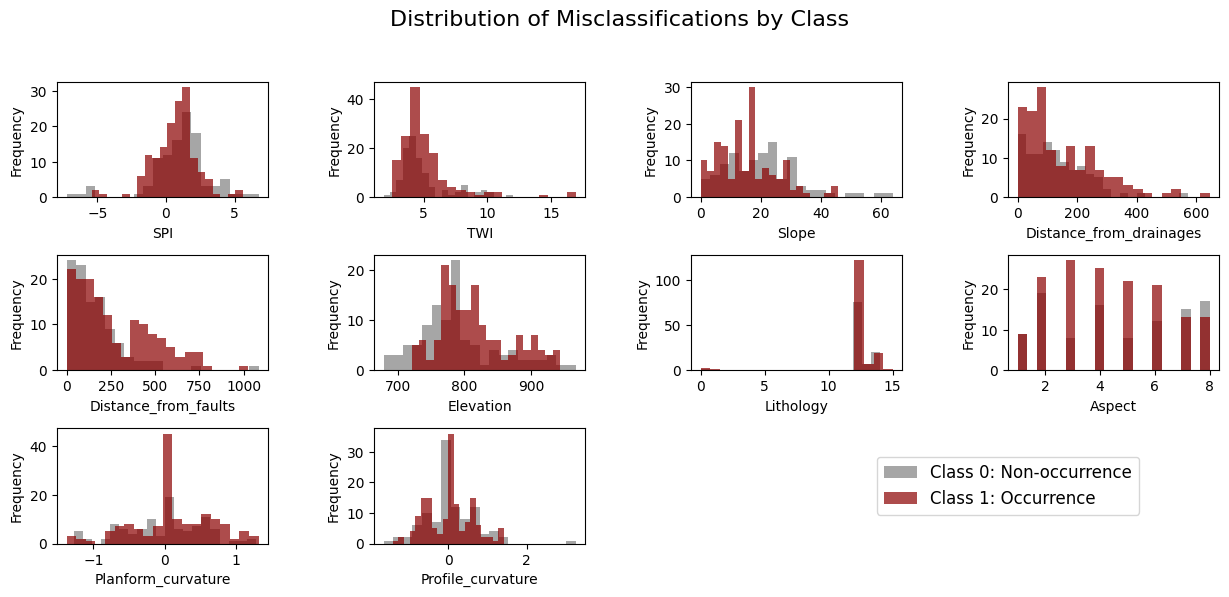

In [102]:
# List of columns to visualize
columns_to_visualize = misclassified_examples_class_0.columns

# Number of columns desired in the grid
num_columns = len(columns_to_visualize)

# Number of rows needed for the grid
num_rows = (num_columns + 3) // 4  # Round up to ensure at least 1 row

# Create the grid of subplots
fig, axs = plt.subplots(num_rows, 4, figsize=(15, 2 * num_rows), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

# Add main title to the figure
fig.suptitle('Distribution of Misclassifications by Class', fontsize=16, y=1.0)

# Iterate over columns and plot histograms
for i, column in enumerate(columns_to_visualize):
    row = i // 4
    col = i % 4

    axs[row, col].hist(misclassified_examples_class_0[column], bins=20, color='gray', alpha=0.7, label='Class 0: Non-occurrence')
    axs[row, col].set_xlabel(column)
    axs[row, col].set_ylabel('Frequency')

    # Check if there are data for class 1 before plotting
    if not misclassified_examples_class_1.empty:
        axs[row, col].hist(misclassified_examples_class_1[column], bins=20, color='darkred', alpha=0.7, label='Class 1: Occurrence')

# Remove empty subplots, if any
for i in range(len(columns_to_visualize), num_rows * 4):
    fig.delaxes(axs.flatten()[i])

# Add a single legend for the entire figure
handles, labels = axs[0, 0].get_legend_handles_labels()

# Position of the last subplot in the last row
pos_last_subplot = axs[-1, -2].get_position()

# Legend position
fig.legend(handles, labels, loc='center', fontsize=12, bbox_to_anchor=(pos_last_subplot.x1 + (pos_last_subplot.x1 - pos_last_subplot.x0) / 2, pos_last_subplot.y0 + (pos_last_subplot.y1 - pos_last_subplot.y0) / 2))

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

In [103]:
# Check error distribution for Lithology
error_distribution_lithology_class_0 = misclassified_examples_class_0['Lithology'].value_counts()
error_distribution_lithology_class_1 = misclassified_examples_class_1['Lithology'].value_counts() if misclassified_examples_class_1 is not None else pd.Series()

# Check error distribution for Aspect
error_distribution_aspect_class_0 = misclassified_examples_class_0['Aspect'].value_counts()
error_distribution_aspect_class_1 = misclassified_examples_class_1['Aspect'].value_counts() if misclassified_examples_class_1 is not None else pd.Series()

# Display the results
print("Error distribution by Lithology (Class 0: Non-occurrence):")
print(error_distribution_lithology_class_0)
print("\nError distribution by Lithology (Class 1: Occurrence):")
print(error_distribution_lithology_class_1)

print("\nError distribution by Aspect (Class 0: Non-occurrence):")
print(error_distribution_aspect_class_0)
print("\nError distribution by Aspect (Class 1: Occurrence):")
print(error_distribution_aspect_class_1)

Error distribution by Lithology (Class 0: Non-occurrence):
Lithology
12    76
14    20
13     7
0      1
Name: count, dtype: int64

Error distribution by Lithology (Class 1: Occurrence):
Lithology
12    122
14     19
13      7
0       3
15      1
1       1
Name: count, dtype: int64

Error distribution by Aspect (Class 0: Non-occurrence):
Aspect
2    19
8    17
4    16
7    15
6    12
1     9
5     8
3     8
Name: count, dtype: int64

Error distribution by Aspect (Class 1: Occurrence):
Aspect
3    27
4    25
2    23
5    22
6    21
7    13
8    13
1     9
Name: count, dtype: int64


In [104]:
from sklearn.inspection import permutation_importance

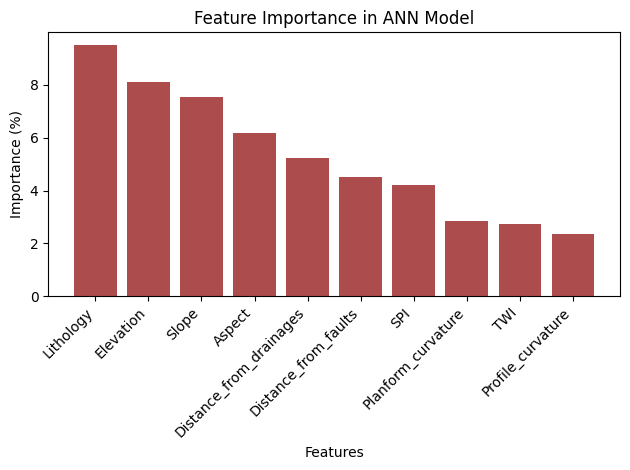

In [105]:
# Calculate permutation importance using X
result_ann = permutation_importance(best_model, X, y, n_repeats=300, random_state=42)

# Extract feature importances
importances_ann = result_ann.importances_mean

# Create a DataFrame to visualize the importances
importance_df_ann = pd.DataFrame({'Feature': X.columns, 'Importance': importances_ann})
importance_df_ann = importance_df_ann.sort_values(by='Importance', ascending=False)

# Convert importances to percentage
importance_df_ann['Importance'] *= 100

# Plot a bar chart to show the ordered feature importances
plt.bar(range(len(importance_df_ann)), importance_df_ann['Importance'], tick_label=importance_df_ann['Feature'], color='darkred', alpha=0.7)
plt.title('Feature Importance in ANN Model')
plt.xlabel('Features')
plt.ylabel('Importance (%)')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.grid(False)
plt.tight_layout()  # Adjust layout to ensure labels do not overlap
plt.show()

In [106]:
# List the variables and their importance
for feature, importance in zip(importance_df_ann['Feature'], importance_df_ann['Importance']):
    print(f'{feature}: {importance:.2f}%')

Lithology: 9.52%
Elevation: 8.13%
Slope: 7.54%
Aspect: 6.19%
Distance_from_drainages: 5.23%
Distance_from_faults: 4.53%
SPI: 4.20%
Planform_curvature: 2.85%
TWI: 2.74%
Profile_curvature: 2.35%


In [107]:
import xgboost as xgb

# Create a DMatrix object for training and test data
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Specify model parameters
params_xgb = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 42
}

# Train the model
num_boost_round = 100
xgb_model = xgb.train(params_xgb, dtrain, num_boost_round=num_boost_round)

# Make predictions on the test set
y_pred_prob_xgb = xgb_model.predict(dtest)
y_pred_class_xgb = [1 if pred > 0.5 else 0 for pred in y_pred_prob_xgb]

# Calculate accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_class_xgb)
print(f'XGBoost model accuracy: {accuracy_xgb:.4f}')

# Calculate feature importance
importance_xgb = xgb_model.get_score(importance_type='weight')

# Normalize feature importance to obtain the percentage
total_importance_xgb = sum(importance_xgb.values())
feature_importance_percentage = {feature: (count / total_importance_xgb) * 100 for feature, count in importance_xgb.items()}

# Sort features by importance in descending order
sorted_feature_importance = sorted(feature_importance_percentage.items(), key=lambda x: x[1], reverse=True)

# Display feature importance in percentage
for feature, importance_percentage in sorted_feature_importance:
    print(f'{feature}: {importance_percentage:.2f}%')

XGBoost model accuracy: 0.7846
Elevation: 16.70%
Distance_from_faults: 14.02%
Distance_from_drainages: 13.33%
TWI: 11.20%
SPI: 10.22%
Planform_curvature: 9.45%
Profile_curvature: 8.57%
Slope: 7.40%
Aspect: 5.60%
Lithology: 3.52%


In [108]:
import joblib
from google.colab import files

# Save the best model using joblib
joblib_file = 'model_train_ann_bhd.pkl'
joblib.dump(best_model, joblib_file)

# Download the .pkl file
files.download(joblib_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [109]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.6 MB/s eta 0:00:00


  0%|          | 0/100 [00:00<?, ?it/s]

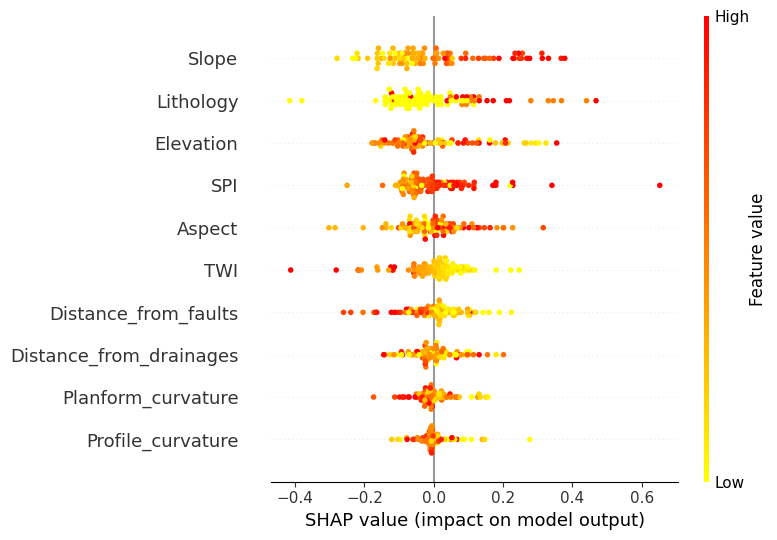

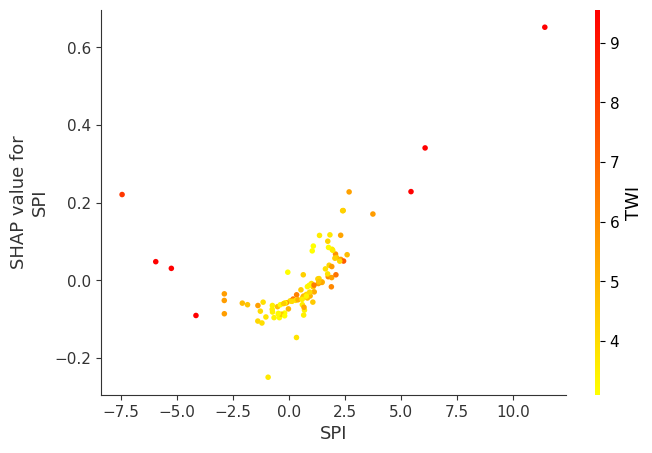

In [110]:
import shap

# Load the saved model
best_model = joblib.load('model_train_ann_bhd.pkl')

# Define the variable names as provided
feature_names = ['SPI', 'TWI', 'Slope', 'Distance_from_drainages', 'Distance_from_faults', 'Elevation', 'Lithology', 'Aspect', 'Planform_curvature', 'Profile_curvature']

# Use a sample of the data for SHAP calculation (to reduce computation time)
X_sample = shap.utils.sample(X, 100)

# Create a wrapper function for prediction
def model_predict(data):
    return best_model.predict(data)

# Create a SHAP explainer using KernelExplainer with the wrapper function
explainer = shap.KernelExplainer(model_predict, X_sample)

# Calculate SHAP values for the sample
shap_values = explainer.shap_values(X_sample)

# Visualize feature importance
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, cmap='autumn_r')

# For a more detailed visualization, you can use the dependence plot
shap.dependence_plot(0, shap_values, X_sample, feature_names=feature_names, cmap=plt.get_cmap('autumn_r'))

In [111]:
# Calculate the mean absolute SHAP value for each variable
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

# Display the feature importance in numbers
for i, name in enumerate(feature_names):
    print(f'Variable {name}: Mean SHAP Importance = {mean_abs_shap[i]}')

Variable SPI: Mean SHAP Importance = 0.07445865079365058
Variable TWI: Mean SHAP Importance = 0.06301730158730139
Variable Slope: Mean SHAP Importance = 0.11607738095238072
Variable Distance_from_drainages: Mean SHAP Importance = 0.0455669047619047
Variable Distance_from_faults: Mean SHAP Importance = 0.05891825396825382
Variable Elevation: Mean SHAP Importance = 0.09704936507936485
Variable Lithology: Mean SHAP Importance = 0.10150865079365058
Variable Aspect: Mean SHAP Importance = 0.06535865079365065
Variable Planform_curvature: Mean SHAP Importance = 0.03472063492063497
Variable Profile_curvature: Mean SHAP Importance = 0.028392539682539724


In [112]:
# Calculate the sum of absolute SHAP values for each variable
total_abs_shap = np.sum(np.abs(shap_values), axis=0)

# Display the feature importance in numbers
for i, name in enumerate(feature_names):
    print(f'Variable {name}: Sum of absolute SHAP values = {total_abs_shap[i]}')

Variable SPI: Sum of absolute SHAP values = 7.445865079365058
Variable TWI: Sum of absolute SHAP values = 6.301730158730138
Variable Slope: Sum of absolute SHAP values = 11.607738095238073
Variable Distance_from_drainages: Sum of absolute SHAP values = 4.55669047619047
Variable Distance_from_faults: Sum of absolute SHAP values = 5.891825396825382
Variable Elevation: Sum of absolute SHAP values = 9.704936507936484
Variable Lithology: Sum of absolute SHAP values = 10.150865079365058
Variable Aspect: Sum of absolute SHAP values = 6.535865079365065
Variable Planform_curvature: Sum of absolute SHAP values = 3.472063492063497
Variable Profile_curvature: Sum of absolute SHAP values = 2.8392539682539724


In [113]:
# Calculate the standard deviation of SHAP values for each variable
std_shap = np.std(shap_values, axis=0)

# Calculate percentiles of SHAP values for each variable
percentile_10 = np.percentile(shap_values, 10, axis=0)
percentile_90 = np.percentile(shap_values, 90, axis=0)

# Display the statistics for each variable
for i, name in enumerate(feature_names):
    print(f'Variable {name}: SHAP Standard Deviation = {std_shap[i]}, 10th Percentile = {percentile_10[i]}, 90th Percentile = {percentile_90[i]}')

Variable SPI: SHAP Standard Deviation = 0.11026062464195824, 10th Percentile = -0.08766507936507906, 90th Percentile = 0.1155059523809521
Variable TWI: SHAP Standard Deviation = 0.09274990769598622, 10th Percentile = -0.11707222222222181, 90th Percentile = 0.08979404761904744
Variable Slope: SHAP Standard Deviation = 0.14643230397660248, 10th Percentile = -0.15946746031746012, 90th Percentile = 0.24491746031746003
Variable Distance_from_drainages: SHAP Standard Deviation = 0.06245836768351037, 10th Percentile = -0.07139682539682529, 90th Percentile = 0.08360952380952363
Variable Distance_from_faults: SHAP Standard Deviation = 0.08114145529574063, 10th Percentile = -0.09539285714285702, 90th Percentile = 0.09768174603174581
Variable Elevation: SHAP Standard Deviation = 0.12288919561962197, 10th Percentile = -0.12055753968253934, 90th Percentile = 0.20234404761904703
Variable Lithology: SHAP Standard Deviation = 0.13842780194872584, 10th Percentile = -0.12156666666666643, 90th Percentile

Random Forest model

In [114]:
'''
# Define the hyperparameter grid for grid search
grid_rf = {'classifier__n_estimators': [1, 2, 5, 10, 18, 20 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 400, 500, 1000, 1200, 1400],
           'classifier__max_features': ['auto', 'sqrt', 'log2', 3, 4, 5],
           'classifier__bootstrap': [True, False],
           'classifier__criterion': ['gini', 'entropy'],
            'classifier__max_depth': [None, 5, 10, 12, 13, 18, 20]
}
print(grid_rf)
'''

"\n# Define the hyperparameter grid for grid search\ngrid_rf = {'classifier__n_estimators': [1, 2, 5, 10, 18, 20 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 400, 500, 1000, 1200, 1400],\n           'classifier__max_features': ['auto', 'sqrt', 'log2', 3, 4, 5],\n           'classifier__bootstrap': [True, False],\n           'classifier__criterion': ['gini', 'entropy'],\n            'classifier__max_depth': [None, 5, 10, 12, 13, 18, 20]\n}\nprint(grid_rf)\n"

In [115]:
# Grid search parameters defined for the model
grid_rf = {'classifier__n_estimators': [400],
           'classifier__max_features': [4],
           'classifier__bootstrap': [True],
           'classifier__criterion': ['gini'],
           'classifier__max_depth': [13]

}
print(grid_rf)

{'classifier__n_estimators': [400], 'classifier__max_features': [4], 'classifier__bootstrap': [True], 'classifier__criterion': ['gini'], 'classifier__max_depth': [13]}


In [116]:
# Create a base classifier
rf = RandomForestClassifier(random_state=42)

 "Pipeline" is for making workflow with standardization and classification in a few lines of code

In [117]:
rf_flow = Pipeline([
    ('preproc', preprocessor),
    ('classifier', rf)
])

In [118]:
# Instantiate the grid search model with 10-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
model_rf = GridSearchCV(rf_flow, param_grid = grid_rf, cv = kfold, scoring=acc_scorer)

In [119]:
model_rf.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         [6,
                                                                          7]),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          8,
                                                                          9])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__bootstrap': [True],
                         'classifier__criterion': ['gini'],
                         'classifier__max_depth': [13],
                         'classifier__max_features': [4],
                         'classifier__n_estimators': [400]},
             scoring=make_scorer(accuracy_score, response_method='predict'))

Best search parameters

In [120]:
model_rf.best_params_

{'classifier__bootstrap': True,
 'classifier__criterion': 'gini',
 'classifier__max_depth': 13,
 'classifier__max_features': 4,
 'classifier__n_estimators': 400}

In [121]:
# Print the best hyperparameters found from all searches
print("Best Hyperparameters Found:")
print(f"- Number of estimators (n_estimators): {model_rf.best_params_['classifier__n_estimators']}")
print(f"- Maximum features (max_features): {model_rf.best_params_['classifier__max_features']}")
print(f"- Bootstrap: {model_rf.best_params_['classifier__bootstrap']}")
print(f"- Criterion: {model_rf.best_params_['classifier__criterion']}")
print(f"- Maximum Depth (max_depth): {model_rf.best_params_['classifier__max_depth']}")

# Print the best cross-validation value
best_score_rf = model_rf.best_score_
print(f"\nBest Cross Validation Value: {best_score_rf}")

Best Hyperparameters Found:
- Number of estimators (n_estimators): 400
- Maximum features (max_features): 4
- Bootstrap: True
- Criterion: gini
- Maximum Depth (max_depth): 13

Best Cross Validation Value: 0.7954061642941099


In [122]:
X.columns

Index(['SPI', 'TWI', 'Slope', 'Distance_from_drainages',
       'Distance_from_faults', 'Elevation', 'Lithology', 'Aspect',
       'Planform_curvature', 'Profile_curvature'],
      dtype='object')

In [123]:
from sklearn.metrics import accuracy_score

# Make predictions using the model
y_pred_rf = model_rf.predict(X_test)

# Calculate overall accuracy
overall_accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Overall accuracy: {overall_accuracy_rf * 100:.2f}%")

# Calculate accuracy for class 0
accuracy_class_0_rf = accuracy_score(y_test[y_test == 0], y_pred_rf[y_test == 0])
print(f"Accuracy for class 0: {accuracy_class_0_rf * 100:.2f}%")

# Calculate accuracy for class 1
accuracy_class_1_rf = accuracy_score(y_test[y_test == 1], y_pred_rf[y_test == 1])
print(f"Accuracy for class 1: {accuracy_class_1_rf * 100:.2f}%")

Overall accuracy: 79.12%
Accuracy for class 0: 85.22%
Accuracy for class 1: 70.02%


In [124]:
# Perform predictions on the training dataset using the trained RF model.
y_pred_rf_train = model_rf.predict(X_train)

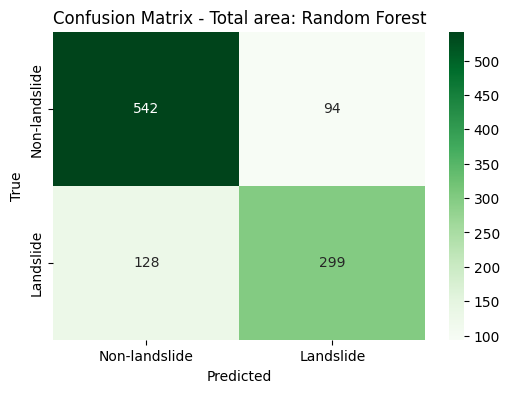

In [125]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Total area: Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0.5, 1.5], ['Non-landslide', 'Landslide'])
plt.yticks([0.5, 1.5], ['Non-landslide', 'Landslide'])
plt.show()

In [126]:
# Calculate evaluation metrics

print("Evaluation metrics for RF:")
print("Accuracy (Test)/Overall Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Accuracy (Training):", accuracy_score(y_train, y_pred_rf_train))

print("Cohen's Kappa Score:", cohen_kappa_score(y_test, y_pred_rf))

print(classification_report(y_test, y_pred_rf, target_names=['non-landslide', 'landslide']))

Evaluation metrics for RF:
Accuracy (Test)/Overall Accuracy: 0.7911571025399812
Accuracy (Training): 0.9769975786924939
Cohen's Kappa Score: 0.5597588230685138
               precision    recall  f1-score   support

non-landslide       0.81      0.85      0.83       636
    landslide       0.76      0.70      0.73       427

     accuracy                           0.79      1063
    macro avg       0.78      0.78      0.78      1063
 weighted avg       0.79      0.79      0.79      1063



In [127]:
# Calculate metrics
overall_accuracy = accuracy_score(y_test, y_pred_rf)
kappa = cohen_kappa_score(y_test, y_pred_rf)

# Extract values from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate Sensitivity and Specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print results
print(f'Overall Accuracy: {overall_accuracy:.4f}')
print(f'Kappa: {kappa:.4f}')
print(f'Sensitivity RF: {sensitivity:.4f}')
print(f'Specificity RF: {specificity:.4f}')

Overall Accuracy: 0.7912
Kappa: 0.5598
Sensitivity RF: 0.7002
Specificity RF: 0.8522


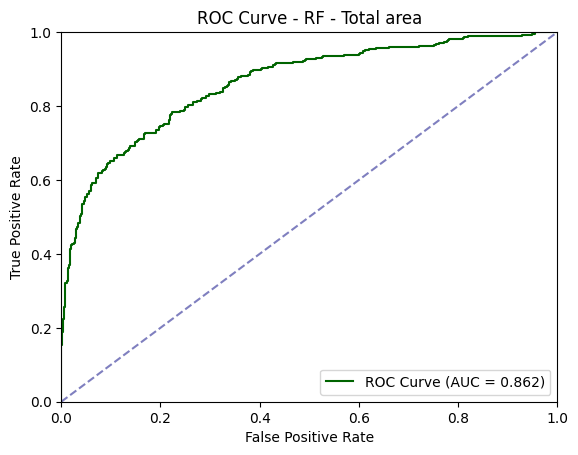

In [128]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_pred_proba_rf = model_rf.predict_proba(X_test)[:, 1]

# Calculate false positive rate and true positive rate
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_pred_proba_rf)

# Calculate area under the ROC curve
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkgreen', lw=1.5, label='ROC Curve (AUC = %0.3f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RF - Total area')
plt.legend(loc="lower right")
plt.show()

In [129]:
# Find indices where the model misclassified class 0
error_indices_class_0_rf = np.where((y_test == 0) & (y_pred_rf != 0))[0]

# Examine features of misclassified examples in class 0
misclassified_examples_class_0_rf = X_test.iloc[error_indices_class_0_rf, :]

# Find indices where the model misclassified class 1
error_indices_class_1_rf = np.where((y_test == 1) & (y_pred_rf != 1))[0]

# Examine features of misclassified examples in class 1
misclassified_examples_class_1_rf = X_test.iloc[error_indices_class_1_rf, :]

# Calculate the number of errors in class 0
num_errors_class_0_rf = misclassified_examples_class_0_rf.shape[0]
print("Number of errors in class 0:", num_errors_class_0_rf)

# Calculate the number of errors in class 1
num_errors_class_1_rf = misclassified_examples_class_1_rf.shape[0]
print("Number of errors in class 1:", num_errors_class_1_rf)

Number of errors in class 0: 94
Number of errors in class 1: 128


In [130]:
# Combine misclassified indices
error_indices_rf = np.concatenate([error_indices_class_0_rf, error_indices_class_1_rf])

# Extract misclassified examples from the original DataFrame
misclassified_examples_rf = df.iloc[error_indices_rf, :]

# Display the misclassified examples DataFrame
print("Misclassified Examples RF:")
print(misclassified_examples_rf)

Misclassified Examples RF:
           SPI        TWI      Slope  Distance_from_drainages  \
0     0.786968   3.368280  28.844410               353.995056   
1     1.090638   4.449178  20.000000               215.783456   
3     3.340890   7.474503  12.600483                70.710678   
4     0.011858   4.139150  12.649111                 0.000000   
23    0.571474   3.582902  21.540659               310.493559   
...        ...        ...        ...                      ...   
1030  1.219500   6.508823   5.656854               138.067013   
1037  2.551394   4.823251  32.000000                45.069391   
1039  2.035681   4.317297  32.249031               150.519932   
1054 -0.540583   3.306327  12.649111               203.485257   
1061  6.087138  10.319366  12.000000                50.000000   

      Distance_from_faults  Elevation  Lithology  Aspect  Planform_curvature  \
0               300.520386      913.0         13       4           -0.147692   
1                55.901699      

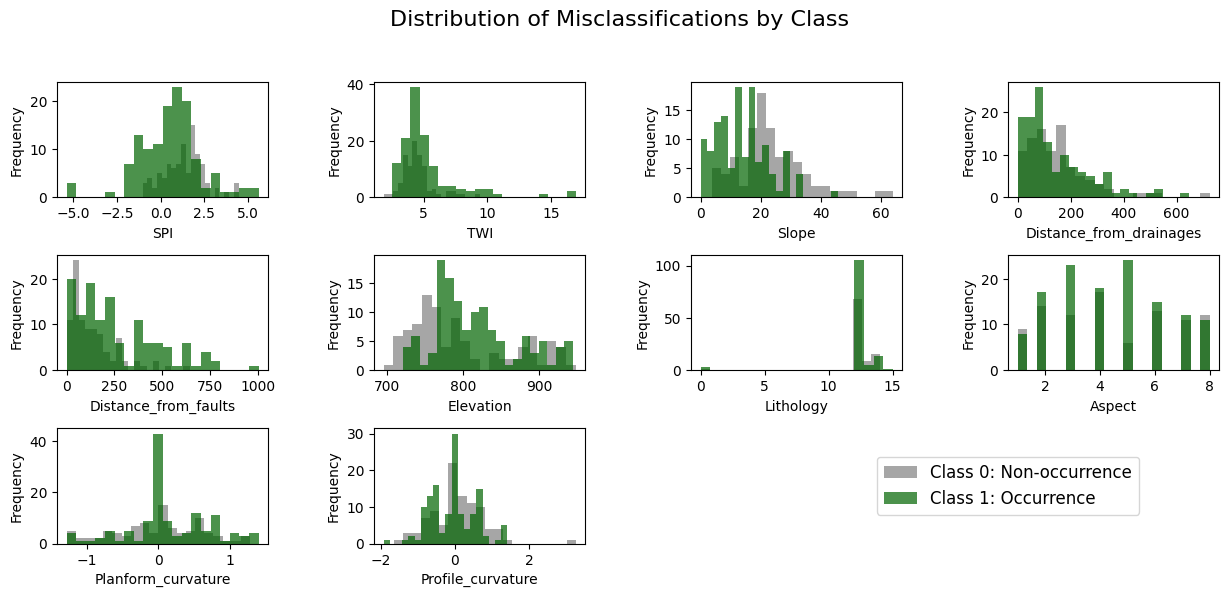

In [131]:
# List of columns to visualize
columns_to_visualize_rf = misclassified_examples_class_0_rf.columns

# Number of columns desired in the grid
num_columns_rf = len(columns_to_visualize_rf)

# Number of rows needed for the grid
num_rows_rf = (num_columns_rf + 3) // 4  # Round up to ensure at least 1 row

# Create the grid of subplots
fig, axs = plt.subplots(num_rows_rf, 4, figsize=(15, 2 * num_rows), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

# Add main title to the figure
fig.suptitle('Distribution of Misclassifications by Class', fontsize=16, y=1.0)

# Iterate over columns and plot histograms
for i, column in enumerate(columns_to_visualize_rf):
    row = i // 4
    col = i % 4

    axs[row, col].hist(misclassified_examples_class_0_rf[column], bins=20, color='gray', alpha=0.7, label='Class 0: Non-occurrence')
    axs[row, col].set_xlabel(column)
    axs[row, col].set_ylabel('Frequency')

    # Check if there are data for class 1 before plotting
    if not misclassified_examples_class_1_rf.empty:
        axs[row, col].hist(misclassified_examples_class_1_rf[column], bins=20, color='darkgreen', alpha=0.7, label='Class 1: Occurrence')

# Remove empty subplots, if any
for i in range(len(columns_to_visualize_rf), num_rows_rf * 4):
    fig.delaxes(axs.flatten()[i])

# Add a single legend for the entire figure
handles, labels = axs[0, 0].get_legend_handles_labels()

# Position of the last subplot in the last row
pos_last_subplot = axs[-1, -2].get_position()

# Legend position
fig.legend(handles, labels, loc='center', fontsize=12, bbox_to_anchor=(pos_last_subplot.x1 + (pos_last_subplot.x1 - pos_last_subplot.x0) / 2, pos_last_subplot.y0 + (pos_last_subplot.y1 - pos_last_subplot.y0) / 2))

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

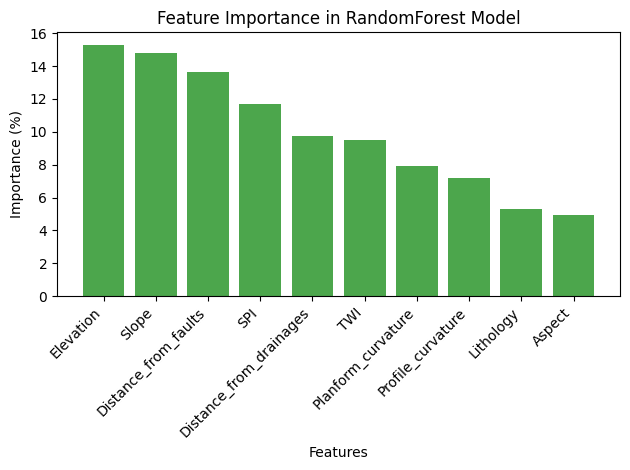

In [132]:
from sklearn.ensemble import RandomForestClassifier

# Train the RandomForest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Access feature importances and feature names
feature_importances = rf.feature_importances_
feature_names = X.columns

# Create a list of tuples (importance, feature name) and sort by importance
sorted_features = sorted(zip(feature_importances, feature_names), reverse=True)

# Unpack the sorted tuples
sorted_importances, sorted_feature_names = zip(*sorted_features)

# Convert importances to percentage
sorted_importances_percentage = [imp * 100 for imp in sorted_importances]

# Plot a bar chart to show the ordered feature importances
plt.bar(range(len(sorted_importances_percentage)), sorted_importances_percentage, tick_label=sorted_feature_names, color='green', alpha=0.7)
plt.title('Feature Importance in RandomForest Model')
plt.xlabel('Features')
plt.ylabel('Importance (%)')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.tight_layout()  # Adjust layout to ensure labels do not overlap
plt.show()

In [133]:
best_model_rf= model_rf.best_estimator_

In [134]:
import joblib
from google.colab import files

# Salve o melhor modelo usando joblib
joblib_file_rf = 'model_train_rf_bhd.pkl'
joblib.dump(best_model_rf, joblib_file_rf)

# Faça o download do arquivo .pkl
files.download(joblib_file_rf)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  0%|          | 0/100 [00:00<?, ?it/s]

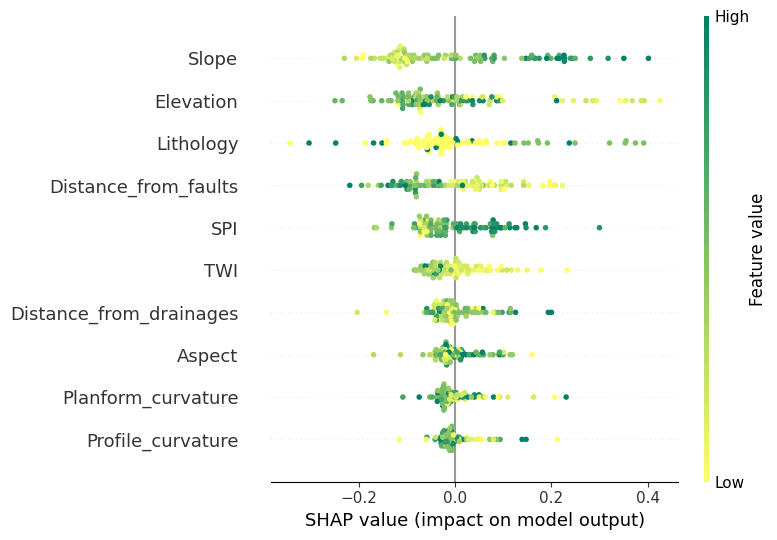

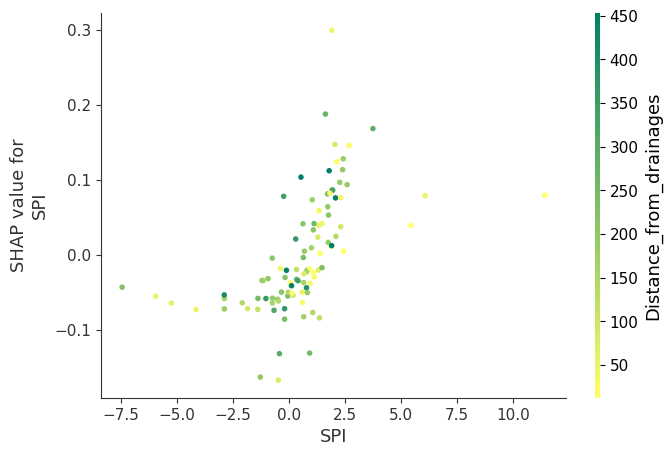

In [135]:
# Load the saved model
best_model_rf_shap = joblib.load('model_train_rf_bhd.pkl')

# Define the variable names as provided
feature_names = ['SPI', 'TWI', 'Slope', 'Distance_from_drainages', 'Distance_from_faults', 'Elevation', 'Lithology', 'Aspect', 'Planform_curvature', 'Profile_curvature']

# Use a sample of the data for SHAP calculation (to reduce computation time)
X_sample = shap.utils.sample(X, 100)

# Create a wrapper function for prediction
def model_predict(data):
    return best_model_rf_shap.predict(data)

# Create a SHAP explainer using KernelExplainer with the wrapper function
explainer_rf_shap = shap.KernelExplainer(model_predict, X_sample)

# Calculate SHAP values for the sample
shap_values_rf_shap = explainer_rf_shap.shap_values(X_sample)

# Visualize feature importance
shap.summary_plot(shap_values_rf_shap, X_sample, feature_names=feature_names, cmap='summer_r')

# For a more detailed visualization, you can use the dependence plot
shap.dependence_plot(0, shap_values_rf_shap, X_sample, feature_names=feature_names, cmap='summer_r')

In [136]:
# Calculate the mean absolute SHAP value for each variable
mean_abs_shap_rf = np.mean(np.abs(shap_values_rf_shap), axis=0)

# Display the feature importance in numbers
for i, name in enumerate(feature_names):
    print(f'Variable {name}: Mean SHAP Importance RF = {mean_abs_shap_rf[i]}')

Variable SPI: Mean SHAP Importance RF = 0.06214253968253952
Variable TWI: Mean SHAP Importance RF = 0.04340420634920626
Variable Slope: Mean SHAP Importance RF = 0.1202945238095236
Variable Distance_from_drainages: Mean SHAP Importance RF = 0.038528333333333296
Variable Distance_from_faults: Mean SHAP Importance RF = 0.07890452380952363
Variable Elevation: Mean SHAP Importance RF = 0.10317666666666642
Variable Lithology: Mean SHAP Importance RF = 0.08366857142857123
Variable Aspect: Mean SHAP Importance RF = 0.03231444444444441
Variable Planform_curvature: Mean SHAP Importance RF = 0.031138015873016043
Variable Profile_curvature: Mean SHAP Importance RF = 0.026519841269841412


In [137]:
# Calculate the sum of absolute SHAP values for each variable
total_abs_shap_rf = np.sum(np.abs(shap_values_rf_shap), axis=0)

# Display the feature importance in numbers
for i, name in enumerate(feature_names):
    print(f'Variable {name}: Sum of absolute SHAP values = {total_abs_shap_rf[i]}')

Variable SPI: Sum of absolute SHAP values = 6.214253968253952
Variable TWI: Sum of absolute SHAP values = 4.340420634920626
Variable Slope: Sum of absolute SHAP values = 12.02945238095236
Variable Distance_from_drainages: Sum of absolute SHAP values = 3.85283333333333
Variable Distance_from_faults: Sum of absolute SHAP values = 7.890452380952364
Variable Elevation: Sum of absolute SHAP values = 10.317666666666641
Variable Lithology: Sum of absolute SHAP values = 8.366857142857123
Variable Aspect: Sum of absolute SHAP values = 3.231444444444441
Variable Planform_curvature: Sum of absolute SHAP values = 3.1138015873016043
Variable Profile_curvature: Sum of absolute SHAP values = 2.651984126984141


In [138]:
# Calculate the standard deviation of SHAP values for each variable
std_shap_rf = np.std(shap_values_rf_shap, axis=0)

# Calculate percentiles of SHAP values for each variable
percentile_10_rf = np.percentile(shap_values_rf_shap, 10, axis=0)
percentile_90_rf = np.percentile(shap_values_rf_shap, 90, axis=0)

# Display the statistics for each variable
for i, name in enumerate(feature_names):
    print(f'Variable {name}: SHAP Standard Deviation = {std_shap_rf[i]}, 10th Percentile = {percentile_10_rf[i]}, 90th Percentile = {percentile_90_rf[i]}')

Variable SPI: SHAP Standard Deviation = 0.07750296350773758, 10th Percentile = -0.07254444444444422, 90th Percentile = 0.09758055555555536
Variable TWI: SHAP Standard Deviation = 0.057928767788579215, 10th Percentile = -0.0612841269841269, 90th Percentile = 0.0716829365079364
Variable Slope: SHAP Standard Deviation = 0.14285762804811755, 10th Percentile = -0.13451269841269808, 90th Percentile = 0.2174960317460313
Variable Distance_from_drainages: SHAP Standard Deviation = 0.05568939209501493, 10th Percentile = -0.04204246031746027, 90th Percentile = 0.06568293650793652
Variable Distance_from_faults: SHAP Standard Deviation = 0.09697884850416204, 10th Percentile = -0.11378253968253953, 90th Percentile = 0.11939166666666676
Variable Elevation: SHAP Standard Deviation = 0.14008236072497166, 10th Percentile = -0.1183337301587298, 90th Percentile = 0.2252960317460311
Variable Lithology: SHAP Standard Deviation = 0.12347930434938324, 10th Percentile = -0.09178253968253934, 90th Percentile = 

Comparison between models

In [139]:
from sklearn.metrics import recall_score, f1_score, accuracy_score, roc_auc_score

y_probas = [y_pred_proba_ann, y_pred_proba_rf]
model_names = ['ANN', 'Random Forest']

# Create lists to store the metrics
recall_scores = []
f1_scores = []
accuracy_scores = []
roc_auc_scores = []

# Loop through the probability prediction results
for y_proba in y_probas:
    # Convert probabilities to binary labels (using a threshold, e.g., 0.5)
    y_pred = (y_proba > 0.5).astype(int)

    # Calculate the metrics
    recall = recall_score(y_test, y_pred)  # Replace y_test with your actual labels
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)  # Calculate ROC AUC using probabilities

    # Store the metrics in the lists
    recall_scores.append(recall)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)
    roc_auc_scores.append(roc_auc)

# Create a DataFrame with the metrics
metrics_df = pd.DataFrame({
    'Model': model_names,
    'Recall': recall_scores,
    'F1 Score': f1_scores,
    'Accuracy': accuracy_scores,
    'ROC AUC': roc_auc_scores
})

# Display the table
print(metrics_df)

           Model    Recall  F1 Score  Accuracy   ROC AUC
0            ANN  0.641686  0.680745  0.758231  0.809001
1  Random Forest  0.700234  0.729268  0.791157  0.862136


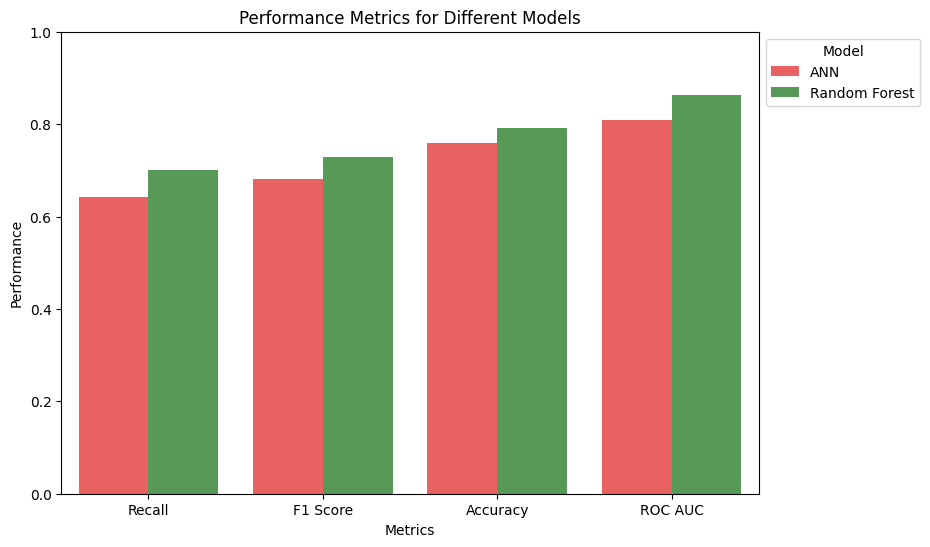

In [140]:
# Map colors to each model
model_colors = {'ANN': 'red', 'Random Forest': 'green'}

# Add a color column to the DataFrame
metrics_df['Color'] = metrics_df['Model'].map(model_colors)

# Melt the DataFrame for easier use with seaborn
metrics_df_melted = pd.melt(metrics_df, id_vars=['Model', 'Color'], var_name='Metric', value_name='Performance')

# Create a grouped bar chart with specific colors for each model
plt.figure(figsize=(9, 6))
ax = sns.barplot(x='Metric', y='Performance', hue='Model', data=metrics_df_melted, palette=list(metrics_df_melted['Color']))

# Add transparency to the bars
for bar in ax.patches:
    bar.set_alpha(0.7)

# Add titles and axis labels
plt.title('Performance Metrics for Different Models')
plt.xlabel('Metrics')
plt.ylabel('Performance')

# Set the y-axis to range from 0 to 1
ax.set_ylim(0, 1)

# Display the chart
plt.legend(title='Model', bbox_to_anchor=(1, 1))
plt.show()

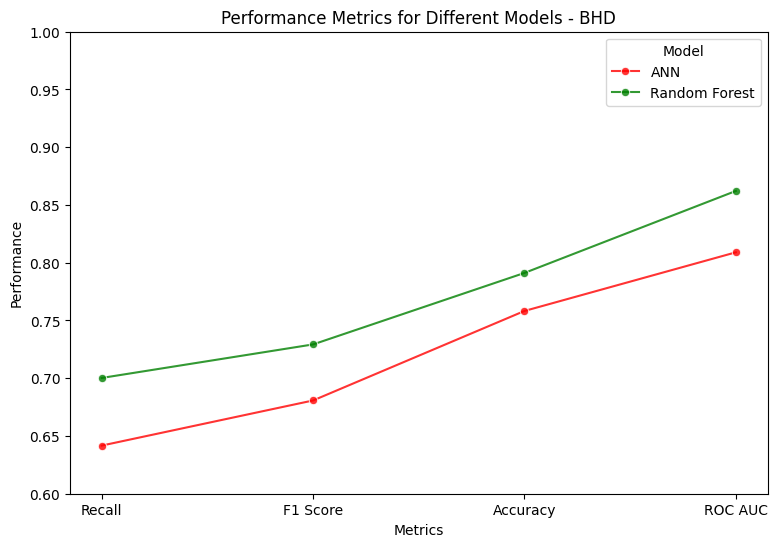

In [154]:
# Create a line plot with specific colors for each model
plt.figure(figsize=(9, 6))
ax = sns.lineplot(x='Metric', y='Performance', hue='Model', data=metrics_df_melted, palette=model_colors, marker='o', alpha=0.8)

# Add titles and axis labels
plt.title('Performance Metrics for Different Models - BHD')
plt.xlabel('Metrics')
plt.ylabel('Performance')

ax.set_ylim(0.6, 1)

# Display the chart
plt.legend(title='Model', bbox_to_anchor=(1, 1))
plt.show()

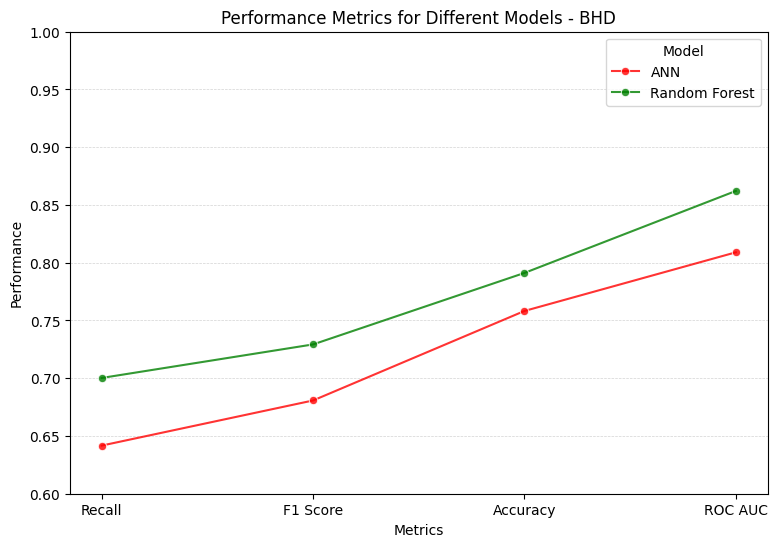

In [155]:
# Create a line plot with specific colors for each model
plt.figure(figsize=(9, 6))
ax = sns.lineplot(x='Metric', y='Performance', hue='Model', data=metrics_df_melted, palette=model_colors, marker='o', alpha=0.8)

# Add titles and axis labels
plt.title('Performance Metrics for Different Models - BHD')
plt.xlabel('Metrics')
plt.ylabel('Performance')

# Set the y-axis to range from 0.80 to 1
ax.set_ylim(0.6, 1)

# Add horizontal dashed grid lines in light gray
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray', axis='y')

# Display the chart
plt.legend(title='Model', bbox_to_anchor=(1, 1))
plt.show()

## Plotting ROC curves for the 2 models

In [143]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [144]:
pred_prob_ann=model_ann.predict_proba(X_test)[:,1]
fpr_ann, tpr_ann, threshold1 = roc_curve(y_test, pred_prob_ann, pos_label=1)
# AUC score that summarizes the ROC curve
roc_auc_ann = auc(fpr_ann, tpr_ann)

In [145]:
pred_prob_rf=model_rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, threshold1 = roc_curve(y_test, pred_prob_rf, pos_label=1)
# AUC score that summarizes the ROC curve
roc_auc_rf = auc(fpr_rf, tpr_rf)

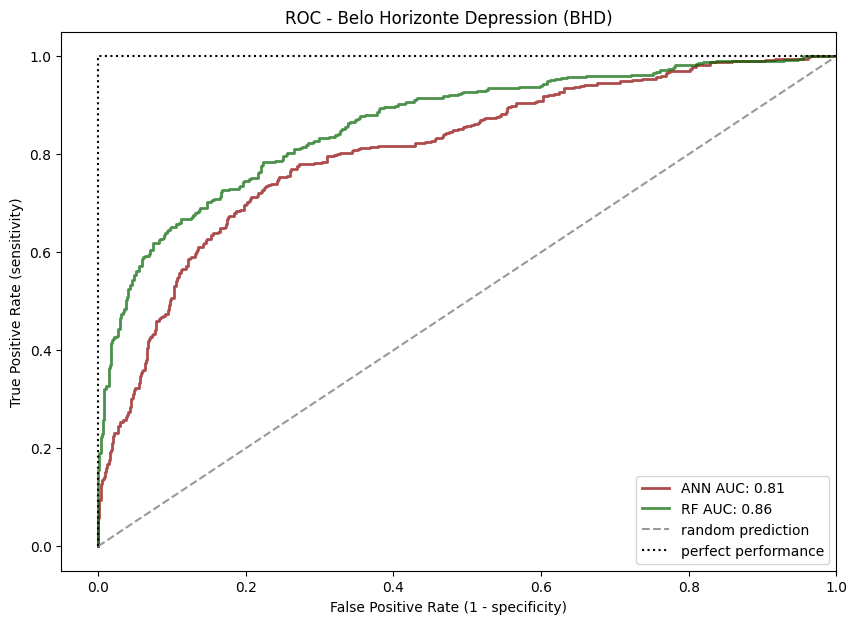

In [146]:
# AUC score that summarizes the ROC curve
f, ax = plt.subplots(figsize=(10,7))
plt.plot(fpr_ann,tpr_ann, color ='darkred', alpha=0.7, lw=2, label= 'ANN AUC: {:.2f}'.format(roc_auc_ann))
plt.plot(fpr_rf,tpr_rf, color ='darkgreen',alpha=0.7, lw=2, label='RF AUC: {:.2f}'.format(roc_auc_rf))
plt.plot([0, 1], [0, 1],
         linestyle = '--',
         color = (0.6, 0.6, 0.6),
         label = 'random prediction')
plt.plot([0, 0, 1], [0, 1, 1],
         linestyle = ':',
         color = 'black',
         label = 'perfect performance')
plt.xlim([-.05, 1.0])
plt.ylim([-.05, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)')
plt.ylabel('True Positive Rate (sensitivity)')
plt.title('ROC - Belo Horizonte Depression (BHD)')
plt.legend(loc="lower right")

plt.show()

## Making susceptibility maps with our trained classifiers

Predicting probability with trained ANN classifier

In [147]:
result_ann = stack.predict_proba(model_ann)

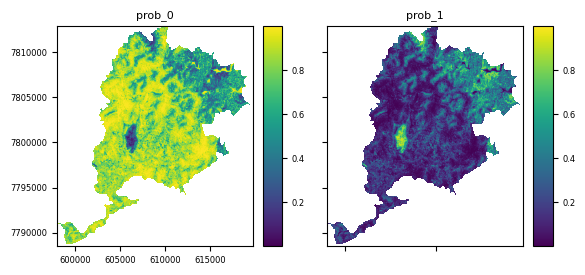

In [148]:
result_ann.plot()
plt.show()

In [149]:
result_ann.write(r"probability_ann_BHD.tif")

Raster Object Containing 2 Layers
    attribute                                             values
0       names                                   [prob_0, prob_1]
1       files  [probability_ann_BHD.tif, probability_ann_BHD....
2        rows                                               1953
3        cols                                               1737
4         res                                       (12.5, 12.5)
5  nodatavals  [-3.4028234663852886e+38, -3.4028234663852886e...


Predicting probability with trained RF classifier

In [150]:
result_rf = stack.predict_proba(model_rf)

Plotting probabilities

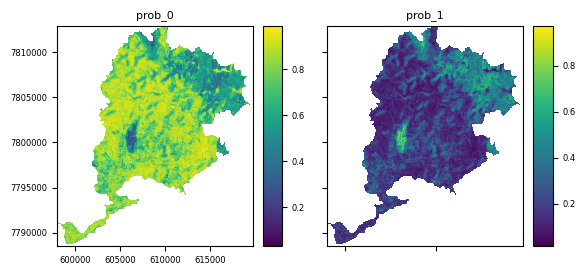

In [151]:
result_rf.plot()
plt.show()

Saving the result as a .tif file

In [152]:
result_rf.write(r"probability_rf_BHD.tif")

Raster Object Containing 2 Layers
    attribute                                             values
0       names                                   [prob_0, prob_1]
1       files   [probability_rf_BHD.tif, probability_rf_BHD.tif]
2        rows                                               1953
3        cols                                               1737
4         res                                       (12.5, 12.5)
5  nodatavals  [-3.4028234663852886e+38, -3.4028234663852886e...


The end